In [1656]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from tqdm.auto import tqdm
import statsmodels.stats
from statsmodels.stats.contingency_tables import StratifiedTable
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
from matplotlib.pyplot import figure
plt.style.use('ggplot')
import scipy.stats as sps
from scipy.stats import mode
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from statsmodels.regression.linear_model import OLS
from scipy.stats import norm
import requests
import json
from urllib.parse import urlencode
from scipy.stats import norm
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

                                            Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

  

Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя
age – возраст
attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 
просмотры
лайки
​
 ∗1000)
coins – число монеток (внутренняя валюта)
country – страна  
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
gender – пол
age_filter_start  – фильтр поиска, мин. значение 
age_filter_end  – фильтр поиска, макс. значение 
views_count – число полученных оценок 
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
is_premium –  является ли премиум
total_revenue – нормированная выручка
 
transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя
country – страна
joined_at – дата и время регистрации
paid_at – дата и время покупки
revenue – нормированная выручка
payment_id – идентификатор платежа
from_page – откуда пользователь перешел на страницу оплаты
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)
 
Файлы:
 - users_test – информация о пользователях в тестовой группе. 
 - users_control_1 – информация о пользователях в первой контрольной группе. 
 - users_control_2 – информация о пользователях во второй контрольной группе . 
 - transactions_test – информация о платежах пользователей в тестовой группе. 
 - transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
 - transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

# Выгрузка данных и очистка  данных

## загрузка данных

In [1657]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
 
a = ['https://disk.yandex.ru/d/L8HxRYDn2l4h9A',
     'https://disk.yandex.ru/d/YT6OWRK2cTWfLg',
     'https://disk.yandex.ru/d/TxOD_JxnkMd4mA',
     'https://disk.yandex.ru/d/84jzzJeQ4tqVyg',
     'https://disk.yandex.ru/d/_pOo7mrDCZZMyA',
     'https://disk.yandex.ru/d/3viYBnm7cyihkQ']   
public_key_3_3 = 'https://disk.yandex.ru/d/L8HxRYDn2l4h9A'
public_key_2_2 = 'https://disk.yandex.ru/d/YT6OWRK2cTWfLg'
public_key_1_1 = 'https://disk.yandex.ru/d/TxOD_JxnkMd4mA'
public_key_1 = 'https://disk.yandex.ru/d/84jzzJeQ4tqVyg'
public_key_2 = 'https://disk.yandex.ru/d/_pOo7mrDCZZMyA'
public_key_3 = 'https://disk.yandex.ru/d/3viYBnm7cyihkQ'

# Получаем загрузочную ссылку 
b = 0
j = []
for i in a:
    j.append((requests.get(base_url + urlencode(dict(public_key= i)))).json()['href'])        
#формируем датафрейм
df1_1 = pd.read_csv(j[2], sep=';')
df2_2 = pd.read_csv(j[1], sep=';')
df3_3 = pd.read_csv(j[0], sep=';')
df1 = pd.read_csv(j[3], sep=';')
df2 = pd.read_csv(j[4], sep=';')
df3 = pd.read_csv(j[5], sep=';')


 ## Объединение данных о транзакциях в один датафрейм

In [1658]:
df1.head(5)#посмотрим на данные

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [1659]:
df1.info() #посмотрим тип колонок

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [1660]:
df1['uid'].isna().sum()#посчитаем кол-во пропущенных значений

630

In [1661]:
df1 = df1[df1['uid'].isna()==False] # оставляем только не пустые строки

In [1662]:
df1 = pd.concat([df1,df2,df3]) # объедием 3 датафрейма последовательно

In [1663]:
df1.head(5)#просмотрим полученный датасет

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


## Объединим записи об одном и том же юзере в одну запись 

In [1664]:
df1_1 = df1_1.assign(group='A1')
df2_2 = df2_2.assign(group='A2')
df3_3 = df3_3.assign(group='B1')
#добавляем столбцы индикаторы групп, для того чтобы их индетифицировать

In [1665]:
df_users= pd.concat([df1_1, df2_2,df3_3])#соединим 3 даафрейма в один друг за другом в конец списка

Рассмотрим наличие дупликатов и их причины

In [1666]:
df1.query('product_type == "premium_no_trial"')\
   .query('uid.duplicated()==True')\
   .head(10) #выводим список дупликатов для юзеров с премиумом без пробной подписки                     

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
103,892366260.0,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-11-14 16:50:00,6292.0,147.0,left_sidebar_menu,premium_no_trial
141,892393119.0,Italy,2017-10-15 00:34:00,2017-10-21 13:09:00,1807.0,68.0,none,premium_no_trial
262,891822480.0,Italy,2017-10-26 22:27:00,2017-07-11 00:04:00,6292.0,147.0,promo_09,premium_no_trial
269,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,147.0,autoreply_message,premium_no_trial
270,892290105.0,United States of America,2017-10-16 22:03:00,2017-10-23 12:50:00,6292.0,147.0,promo_09,premium_no_trial
347,892101909.0,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial
351,891264903.0,United States of America,2017-06-11 16:02:00,2017-09-11 10:32:00,3874.0,147.0,none,premium_no_trial
144,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,147.0,none,premium_no_trial
195,892435536.0,United States of America,2017-10-14 02:54:00,2017-11-14 04:57:00,4537.0,147.0,dating,premium_no_trial
196,892139829.0,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-23 13:54:00,5161.0,147.0,promo_09,premium_no_trial


In [1667]:
df1.query('product_type == "trial_premium"')\
   .query('uid.duplicated()==True')#выводим список дупликатов для юзеров с премиумом с пробной подписки 

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
181,891297711.0,Spain,2017-06-11 01:35:00,2017-11-13 03:42:00,12818.0,147.0,autoreply_message,trial_premium


Характер ошибок в данном датасете:
   - записи полностью совпадают по времени, но отличаются по payment_id
   - записи полностью совпадают, но отличаются по дате от 1 дня до нескольких
Будем считать, что это системная ошибка при присваивании времени

In [1668]:
uniq_uid = df1.groupby('uid',as_index=False).aggregate({'product_type':[set]})
#группируем юзеров по uid всю информацию из пункта product_type записываем в product_set

In [1669]:
uniq_uid.columns = [''.join(col).rstrip('') for col in uniq_uid.columns.values]
#выравниваю в один уровень название колонок

In [1670]:
sum_revenue = df1.groupby('uid',as_index=False).agg({'revenue':'sum'}).sort_values('revenue')
#создадим датафрейм в котором, у каждого юзера посчитаем сумму всех транзакции

In [1671]:
list_not_correct = sum_revenue[sum_revenue['revenue'].isin(df_users.query('total_revenue>27')\
          .groupby('uid',as_index= False)\
          .agg({'total_revenue':'sum'})\
          .sort_values('total_revenue')\
          .total_revenue) == False].uid

In [1672]:
list_not_correct 

525    960936960.0
495    892355163.0
465    892275462.0
Name: uid, dtype: float64

In [1673]:
df1.query('uid in @list_not_correct')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type
303,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type
64,892275462.0,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083.0,19.0,coins_popup,other_type
154,892275462.0,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885.0,68.0,super_popup,other_type


In [1674]:
df_users.query('uid in @list_not_correct')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,A1
3370,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,0,A1
2070,892275462,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885,B1


В наших данных есть столбец revenue - это выручка с одной транзакции,  а столбец total_revenue - это 
накопительная сумма всей выручки за все время проведения эксперимента. Это подтверждается нашей проверкой, из всех 256 юзеров
совершивших транзакции, только у 3 юзеров сумма revenue = total_revenue из них один юзер крайне подозрителен (дата совершения
покупки 2016). Это нам позволяет оставить только 1 запись для каждого юзера.

In [1675]:
df1 = df1.drop_duplicates(subset='uid',keep='first') # удаляем дупликаты оставляя первую появившуюся запись

In [1676]:
df1 = df1.merge(uniq_uid,on = ['uid'],how='left').fillna(0)

In [1677]:
df1 = df1.drop(columns=['from_page','product_type'])

Посмотрим есть ли дубликаты записей об юзерах

In [1678]:
df1.loc[df1['uid'] == 892333905] # посмотрим траты юзера с большим количеством покупок

,uid,country,joined_at,paid_at,revenue,payment_id,product_typeset
6,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,"{coins, premium_no_trial, other_type}"


 - оставляем одну строчку среди дубликатов, так как нам важно,чтобы id не повтоярлось в противном случае наши данные будут 
зависимыми и искажать результаты. Т.е если у нас останется 3 строчки с одним и тем же id при смердживании с данными о 
транзакциях, получиться 3 строчки с total_revenue, значение увеличиться в 3 раза, это не допустимо поэтому удаляем дубликаты.

In [1679]:
def typeset(row): 
    if 'premium_no_trial' in  row['product_typeset']:
        return 'premium_no_trial'
    elif 'trial_premium' in  row['product_typeset']:
        return 'trial_premium'
    elif 'trial_premium'and'premium_no_trial' in row['product_typeset']:
        return 'premium_no_trial'
    else:
        return 'other'

In [1680]:
df1['product_typeset'] = df1.apply(typeset, axis=1)
#создаем категариальную колонку,указывающая на что производились покупки юзером

Изменяем тип кололок на удобный для дальнейшего использования

In [1681]:
df1['uid']=df1['uid'].astype('int')
df1['revenue']=df1['revenue'].astype('int')
df1['payment_id']=df1['payment_id'].astype('int')
df1['joined_at'] = pd.to_datetime(df1['joined_at'])
df1['paid_at'] = pd.to_datetime(df1['paid_at'])

In [1682]:
df1.info()#проверяем,что измение колонк прошло успешно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526 entries, 0 to 525
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   uid              526 non-null    int32         
 1   country          526 non-null    object        
 2   joined_at        526 non-null    datetime64[ns]
 3   paid_at          526 non-null    datetime64[ns]
 4   revenue          526 non-null    int32         
 5   payment_id       526 non-null    int32         
 6   product_typeset  526 non-null    object        
dtypes: datetime64[ns](2), int32(3), object(2)
memory usage: 26.7+ KB


## Объединение данных о юзерах в один датафрейм

In [1683]:
df_users.head(5) # посмотрим на получившийся датафрейм

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,A1
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,A1
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0,A1
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0,A1
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0,A1


In [1684]:
df_users.loc[(df_users['visit_days'].isna() == True),'visit_days'].sum()
# проверял, юзеров с пропущенным столбцом visit days, ничего подозрительного не обнаружил

0

In [1685]:
df_users.loc[df_users['was_premium'].isna() == True,'was_premium'] = 0
df_users.loc[df_users['is_premium'].isna() == True,'is_premium'] = 0
df_users.loc[df_users['coins'].isna() == True,'coins'] = 0
#пустые колонки заменим на 0

Заменяем пустые значения на 0, так как предполагаем,что это произошло из-за системной ошибки.
Если удалить эти данные, то мы потеряем много юзеров,которые приносят нам прибыль и наша данные будут не репрезентативными.

In [1686]:
df_users['coins']=df_users['coins'].astype('int')
df_users['was_premiums']=df_users['was_premium'].astype('int')
df_users['is_premium']=df_users['is_premium'].astype('int')
df_users['visit_days']=df_users['visit_days'].astype('str')
#Изменяем тип кололок на удобный для дальнейшего использования

 # Очистка данных колонок 

## Колонка 'Age'

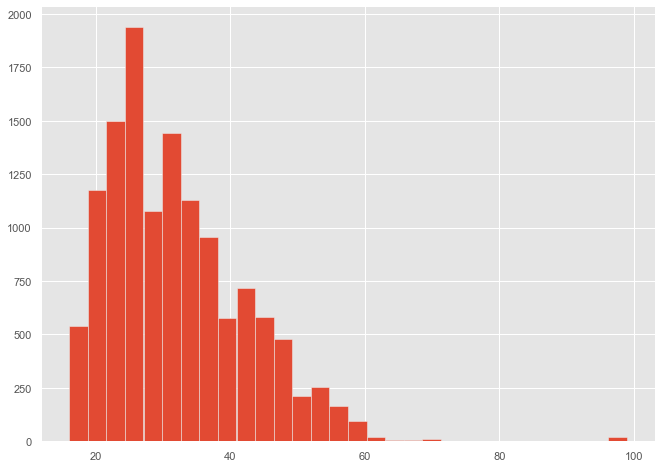

In [1687]:
df_users.age.hist(bins = 30); # гистограмма распределения возраста

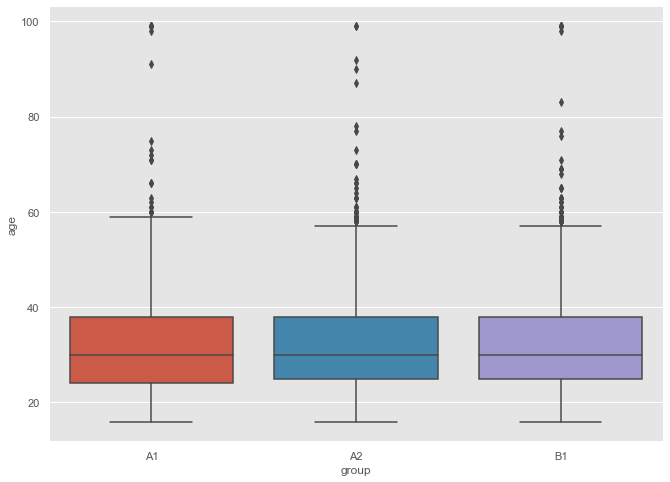

In [1688]:
ax = sns.boxplot(x='group',y='age',data=df_users)

In [1689]:
df_users.sort_values(by='age').tail(10)# посмотрим на самых возрастных юзеров

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
4265,891175101,99,587,0,Canada,1,1,16,24,182,0.0,0,0,B1,0
2103,892185039,99,759,0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9",1,43,49,79,1.0,1,7332,A1,1
2571,891559305,99,440,0,Germany,"1,2",0,24,37,25,0.0,0,0,A2,0
2281,891321930,99,0,0,United States of America,"1,2,4,6",1,50,70,3,0.0,0,0,B1,0
1747,892285575,99,166,0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,2...",1,50,70,6,0.0,0,0,B1,0
773,891746646,99,300,0,Italy,nan,1,50,70,10,0.0,0,0,A1,0
2238,892321845,99,500,0,United States of America,nan,1,22,99,4,0.0,0,0,A1,0
2374,891305103,99,666,0,France,"1,2,3,4,5,6,7,8,9",1,27,36,9,0.0,0,0,B1,0
2836,891900387,99,333,0,Italy,"1,3,4",1,16,99,3,0.0,0,0,A1,0
2312,891682545,99,0,0,United States of America,nan,1,96,102,0,0.0,0,0,A1,0


Среди юзеров есть возрастная категория старше 90 лет,это может пройзойти из-за:
 - люди скрывают свой возраст
 - ошибка при вводе
 - это реальный возраст
Так как среди них есть юзеры, которые приносят прибыль и их достаточно убирать из датасета не будем их

In [1690]:
df_users.sort_values(by='age').head(10) #посмотрим на самых молодых юзеров

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
2196,891971271,16,1000,0,France,nan,1,13,19,4,0.0,0,0,A2,0
2492,892204905,16,0,0,United States of America,nan,1,16,20,0,0.0,0,0,A2,0
274,891619455,16,0,0,Argentina,nan,1,16,20,0,0.0,0,0,A1,0
2507,892391673,16,166,0,United States of America,"1,2,3,4",1,16,20,12,0.0,0,0,A2,0
2562,892433721,16,0,0,Chile,"2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,20,22,...",1,16,20,0,0.0,0,0,A2,0
2578,891653832,16,0,0,United States of America,"1,2,4,5,7,8,10,11,12,13,15",0,16,19,0,0.0,0,0,A2,0
2173,892422567,16,500,0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,2...",1,16,20,18,0.0,0,0,B1,0
2627,891462984,16,0,0,United States of America,nan,1,16,20,1,0.0,0,0,A2,0
518,892003320,16,0,0,Spain,1,1,13,19,0,0.0,0,0,A2,0
2394,892226001,16,0,0,Canada,"1,2,3,4,5,6,7,8,9,10,11,13,15,16,18,20,22,23,25",1,16,20,0,0.0,0,0,A1,0


In [1691]:
df_users.query('age == 16').groupby('group').count().uid # посмотрим на распределение самых молодых юзеров

group
A1    82
A2    87
B1    82
Name: uid, dtype: int64

Среди юзеров есть также категория людей младше 18 лет, но так как количество этих юзеров распространнено равномерно среди 
групп, а также видимо это не противоречит законам госудатсва, то мы оставляем без изменения эти данные.

## Колонка 'attraction_coeff'

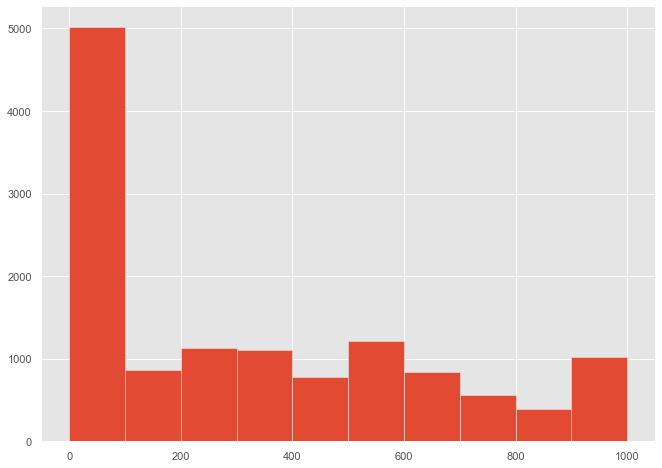

In [1692]:
df_users.attraction_coeff.hist(); #рассмотрим распределение коэффицента привлекательности

In [1693]:
df_users.attraction_coeff.describe() # посмотрим на описательную статистику колонки attraction_coeff

count    12912.000000
mean       315.455545
std        323.488766
min          0.000000
25%          0.000000
50%        250.000000
75%        529.000000
max       1000.000000
Name: attraction_coeff, dtype: float64

In [1694]:
df_users.loc[df_users['attraction_coeff'] == df_users['attraction_coeff'].quantile(1)].head(10)
#просматривал не накручивали ли юзеры себе коэффицент

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
19,891316365,31,1000,0,United States of America,"1,2,3,4,5,7,8,9,10",1,28,34,2,0.0,0,0,A1,0
35,891679653,20,1000,0,France,"3,4,5,6,7,8,10,11,13,14",1,17,23,4,0.0,0,0,A1,0
41,891525432,33,1000,0,France,"1,2,3,4,6,7",1,30,36,2,0.0,0,0,A1,0
60,891174765,56,1000,0,Switzerland,nan,1,41,55,2,0.0,0,0,A1,0
75,891301590,24,1000,0,Chile,"1,2,3,4",1,20,99,3,0.0,0,0,A1,0
82,891230355,33,1000,0,Spain,"1,2,3,5,6,7",1,26,52,3,0.0,0,0,A1,0
87,892084086,28,1000,0,United States of America,nan,1,25,31,1,0.0,0,0,A1,0
98,891247146,39,1000,0,United Arab Emirates,nan,1,36,42,4,0.0,0,0,A1,0
99,892103808,31,1000,0,United Kingdom (Great Britain),"1,2,3,4,5",1,28,34,1,0.0,0,0,A1,0
100,892429812,24,1000,0,United States of America,1,1,21,27,1,0.0,0,0,A1,0


In [1695]:
df_users.loc[(df_users['attraction_coeff']==1000)&(df_users['views_count']>20)]
#просматривал не накручивали ли юзеры себе коэффицент (если было бы много просмотров и коэффицент = 1000, то это вызвало
#бы подозрение)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
668,891122730,25,1000,0,France,"1,2,3",1,22,28,25,0.0,0,0,A1,0
2823,891809739,32,1000,0,Spain,nan,0,29,35,21,0.0,0,0,A2,0
4179,891113163,19,1000,0,United Arab Emirates,nan,0,20,99,23,0.0,0,0,A2,0
4195,891937530,20,1000,0,France,1,1,17,23,21,0.0,0,0,A2,0
3398,892416585,22,1000,0,United States of America,1,1,19,25,22,0.0,0,0,B1,0


Вывод: -Никаких выбросов и подозрительных данных не детектируется

##  Колонка 'total_revenue'

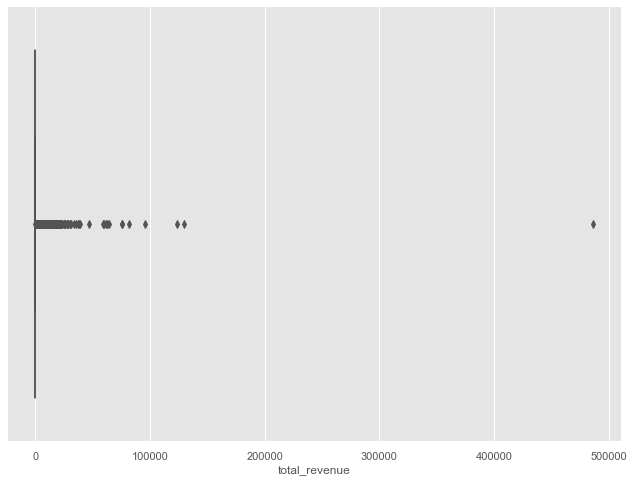

In [1696]:
sns.boxplot(df_users.total_revenue);
# построим на коробчаую диаграмму

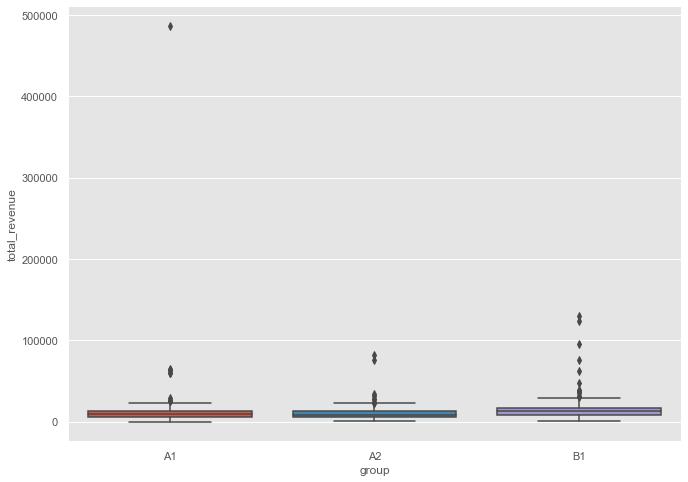

In [1697]:
sns.boxplot(x='group', y='total_revenue', data=df_users[df_users['total_revenue']>0]);

In [1698]:
df_users.loc[(df_users['coins']>0)&(df_users['total_revenue']==0)]
#проверим,есть ли юзеры у которых есть монеты при том,что они не принесли прибыль приложению

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
378,1053059022,21,1,26,Russian Federation,"2,15,16,20,23,27,28,30,60,90,120,150,180",0,62,70,653,1.0,0,0,A2,1
1695,891350991,30,825,3,United States of America,"1,2,3,4,5,6,7,8,9",1,27,33,155,0.0,0,0,A2,0
2326,892052616,18,745,20,Russian Federation,"5,6,12,17",0,18,21,1622,0.0,0,0,A2,0
2080,891402465,28,436,2,United States of America,"2,3,4,5,6,7,8,9,10,11",0,24,30,1080,1.0,0,0,B1,1
2937,905158620,16,579,8466,Russian Federation,"1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,26,...",0,26,33,12831,1.0,1,0,B1,1


Всего 4 юзера имеют внутреннюю валюту и при этом имеют 0 значение в столбце 'total_revenue',есть вероятность,что эти монеты
они получили бонусом от приложения, но это маловероятно так как их всего 4 из 13000, поэтому удалим их из датафрейма.

In [1699]:
df_users = df_users.drop((df_users.loc[(df_users['coins']>0)&(df_users['total_revenue']==0)]).index)
#удаляем юзеров,которые имеют монеты, но не принесли нам прибыль

In [1700]:
df_users.loc[df_users['total_revenue'] !=0 ].sort_values('total_revenue').tail(10)
 #посмотрим на топ 10 юзеров,которые принесли нам максимальную прибыль

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
1815,892366260,26,215,20,United Kingdom (Great Britain),"1,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20...",1,23,29,195,1.0,1,63024,A1,1
874,891383310,22,1000,0,Turkey,1,1,19,83,4,1.0,1,63037,A1,1
2296,892216461,19,293,6,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,1.0,1,64298,A1,1
1216,892307238,29,543,43,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,1.0,1,75647,A2,1
597,891346269,34,204,530,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1,75647,B1,1
1360,891778551,30,290,0,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,1.0,1,81796,A2,1
406,892236423,23,262,378,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1,95823,B1,1
992,892038759,26,323,3,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1,123565,B1,1
3629,891178380,42,275,85,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1,129870,B1,1
1427,892333905,22,175,3608,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1,486330,A1,1


- Юзер с максимальным значением 'total_revenue' скорей всего не является выбросом так как у него куплено 3608 монет, если 
определить стоимость монет, то и получится приблизительно это значение.
- Юзер с минимальным значением 'total_revenue' весьма подозрителен, пока его оставил, но будем держать его в голове.

##  Колонка 'Coins'

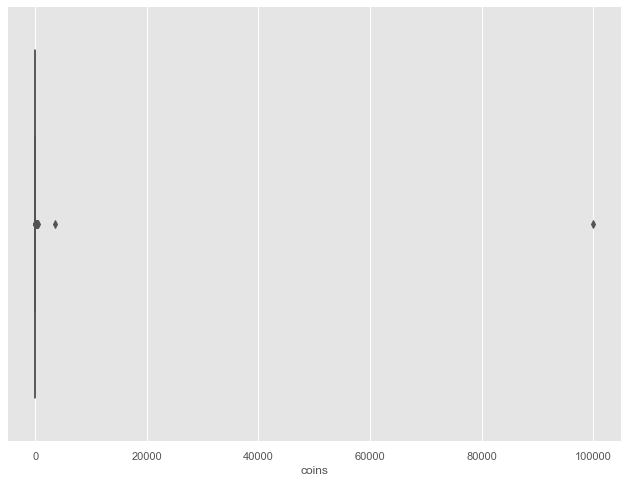

In [1701]:
sns.boxplot(df_users[df_users['coins']>0].coins);

In [1702]:
(df_users[df_users['coins']>0]).coins.describe()

count      165.000000
mean       658.218182
std       7782.870668
min          1.000000
25%          6.000000
50%         10.000000
75%         28.000000
max      99958.000000
Name: coins, dtype: float64

In [1703]:
df_users.sort_values(by='coins').tail(20)# посмотрим на данные юзеров имеющие максиммальное количество монет

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
950,892434141,21,387,64,Turkey,"1,2,3,20",1,18,24,49,1.0,0,9165,B1,1
271,892064328,55,372,68,United States of America,"1,2,3,4,5",1,52,58,212,1.0,1,18902,A2,1
2642,892065108,99,475,72,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,2...",1,16,41,187,1.0,1,47242,B1,1
1353,891765819,41,319,76,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18",1,25,37,667,1.0,1,16601,A1,1
181,891882681,36,408,76,Belgium,"1,2,3,5,6,7,8,9,10,11,12,14,16,17,18,19,20,21",1,33,39,71,1.0,1,20410,B1,1
1925,891452706,41,134,80,Italy,"1,2,3,6,8,11",1,38,44,82,1.0,1,18902,A1,1
1067,891986289,38,145,81,France,"1,2,7,10,16",1,18,35,62,1.0,1,31512,B1,1
3629,891178380,42,275,85,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1,129870,B1,1
851,892186941,44,552,88,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,41,47,38,1.0,1,25207,B1,1
475,891989511,25,166,110,United States of America,"1,2,3",1,16,54,6,1.0,0,12389,A1,1


In [1704]:
df_users = df_users.loc[df_users['uid']!= 960936960] 
#удалим юзер с максимальным количеством монет

Такого не может быть, так как включенный режим премиум слишком мало стоит, плюс очень много просмотров 
относительно других пользователей в 4 раза больше. За такое количество потраченных денег на приложения, не может быть такое
количество coins.
-юзер с датой регистрацие в 2015 наверняка не попал под А/B тестирование -> удаляем его из датасета

##  Колонка "view_count"

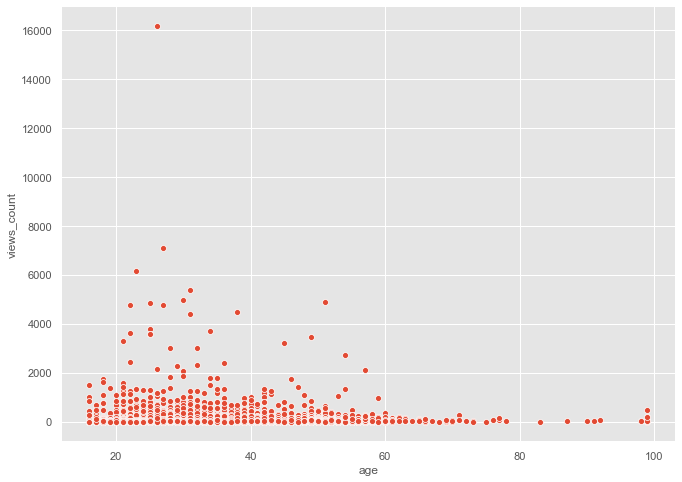

In [1705]:
sns.scatterplot(data=df_users, x = 'age', y= 'views_count');# график зависимости возраста от количества просмотров

In [1706]:
df_users.loc[df_users['views_count']>10000] # посмотрим на юзера с очень большим количеством просмотров

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
225,892032072,26,0,0,United Kingdom (Great Britain),"1,2,3",0,16,99,16157,1.0,0,3588,A2,1


In [1707]:
df_users = df_users.loc[(df_users['uid'] != 892032072)] #удалил юзера

Вывод:
 - Значение просмотров равное 16157 сильно выбивается относительно других данных, а при условии, что attraction_coef = 0
 окончательно дает понять, что это выброс так как из 16157, хоть кто-то да и оставил коээфицент не равный 0


##  Колонка Join_at

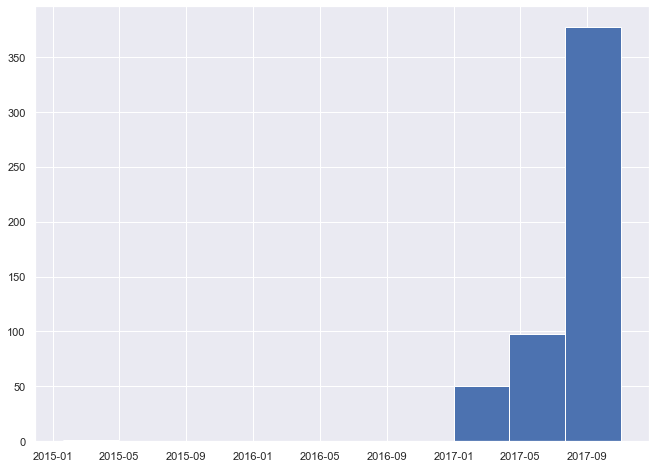

In [1708]:
sns.set(rc={'figure.figsize': (11, 8)})
df1.joined_at.hist();

In [1709]:
calendar= df1.set_index('joined_at').resample(rule='D').count() #создаем словарь с данными о установки приложение

In [1710]:
calendar.loc[calendar['uid']>0] # смотрим на даты установки

,uid,country,paid_at,revenue,payment_id,product_typeset
joined_at,,,,,,
2015-01-19,1,1,1,1,1,1
2017-01-11,14,14,14,14,14,14
2017-02-11,16,16,16,16,16,16
2017-03-11,13,13,13,13,13,13
2017-04-11,15,15,15,15,15,15
2017-05-11,40,40,40,40,40,40
2017-06-11,34,34,34,34,34,34
2017-07-11,16,16,16,16,16,16
2017-08-11,12,12,12,12,12,12


In [1711]:
df1['joined_at'] = df1['joined_at'].apply(lambda x: x.strftime('%Y-%m-%d')) #форматируем столбец в формат год/месяц/день

<AxesSubplot:>

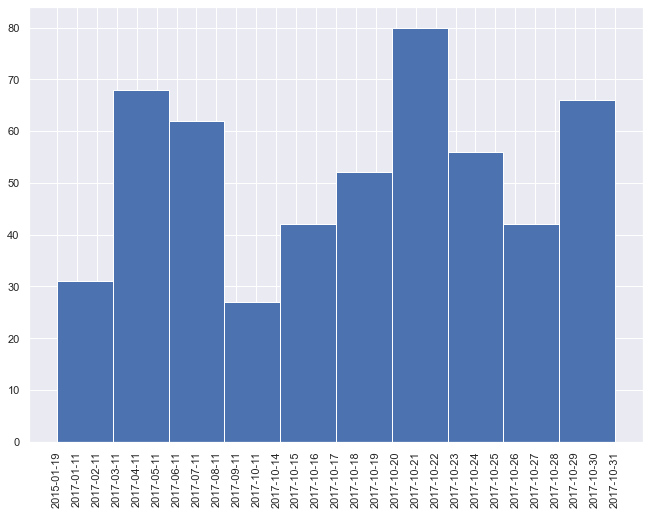

In [1712]:
df1.joined_at.sort_values().hist( xrot=90)

In [1713]:
df1 = df1.loc[df1['joined_at'] != '2015-01'] # удаляю данные о юзере установившем приложение в 2015 году

In [1714]:
df1.head(5) #посмотрим на данные

,uid,country,joined_at,paid_at,revenue,payment_id,product_typeset
0,891319275,France,2017-05-11,2017-12-11 21:57:00,12727,147,trial_premium
1,892421826,Israel,2017-10-14,2017-10-23 12:54:00,14586,147,trial_premium
2,891822480,Italy,2017-10-26,2017-12-11 20:59:00,1911,19,premium_no_trial
3,891367521,Italy,2017-05-11,2017-06-11 19:15:00,1456,127,other
4,892207959,France,2017-10-18,2017-12-11 12:03:00,1261,19,premium_no_trial


Вывод:
- Данные, которые датируются до октября 2017 года имеют системную ошибку, у всех данных меняется только месяц, а день остается
не изменяем. Скорей в связи с системной ошибкой и месяц с днем поменялся местами.
- Неизвестно в какие даты начался A/B тест, поэтому будем предполагать,что он проводился на протяжении 1 месяца: октябрь, так 
как на мой взгляд дольше проводить тест нету смысла, а также если эксперимент провалился мы можем потерять много денег (нерентабельно). Поэтому юзера зарегистривовшегося в 2015 году удалим.

##  Колонка "paid_at"

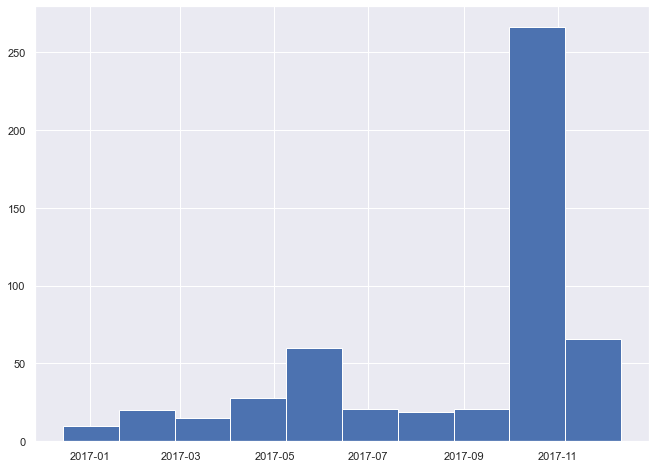

In [1715]:
sns.set(rc={'figure.figsize': (11, 8)})
df1.paid_at.hist();

In [1716]:
calendar2 = df1.set_index('paid_at').resample(rule='D').count() #создаем словарь с данными по дня покупки

In [1717]:
calendar2.loc[calendar2['uid']>0] # смотрим когда в какие дни совершались покупки

,uid,country,joined_at,revenue,payment_id,product_typeset
paid_at,,,,,,
2016-12-14,1,1,1,1,1,1
2017-01-11,9,9,9,9,9,9
2017-02-11,20,20,20,20,20,20
2017-03-11,15,15,15,15,15,15
2017-04-11,28,28,28,28,28,28
2017-05-11,30,30,30,30,30,30
2017-06-11,30,30,30,30,30,30
2017-07-11,21,21,21,21,21,21
2017-08-11,19,19,19,19,19,19


In [1718]:
time1 = df1.loc[(df1['paid_at']>'2017-11-11')|(df1['paid_at']<'2017-01-11')]['paid_at']\
    .apply(lambda x: x.strftime('%Y-%m-%d'))\
    .drop_duplicates()\
    .tolist() #создаем список дат покупок совершенных не в октябре

In [1719]:
time1 # смотрим на этот список

['2017-12-11',
 '2017-11-14',
 '2016-12-14',
 '2017-11-11',
 '2017-11-15',
 '2017-11-13']

In [1720]:
df1['paid_at'] = df1['paid_at'].apply(lambda x: x.strftime('%Y-%m-%d'))# меняю формат столбца в год - месяц - день

In [1721]:
df1 = df1.query('paid_at not in @time1') #оставляет только тех юзеров,которые совершили покупки в октябре

In [1722]:
df1.head(5) #посмотрим на данные

,uid,country,joined_at,paid_at,revenue,payment_id,product_typeset
1,892421826,Israel,2017-10-14,2017-10-23,14586,147,trial_premium
3,891367521,Italy,2017-05-11,2017-06-11,1456,127,other
5,891721851,United States of America,2017-10-29,2017-05-11,4602,146,trial_premium
6,892333905,Italy,2017-10-16,2017-10-16,12610,19,premium_no_trial
7,892380396,Australia,2017-10-15,2017-10-23,13403,147,trial_premium


<AxesSubplot:>

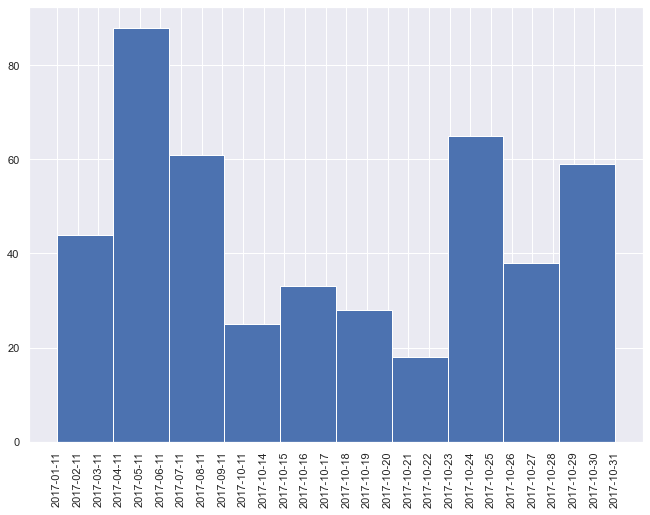

In [1723]:
df1.paid_at.sort_values().hist( xrot=90)

Вывод:
Из-за того, что в данных о дате установки есть ошибки, мы предположили,что А/B тест проходил на протяжение октября, поэтому
логично было оставить в общем датасете данные о покупках юзеров только за октябрь.

##  Колонка "payment_id	"

In [1724]:
df1['payment_id'].value_counts() #посмотрим на распределение payment id

147    278
19      73
146     46
67      30
68      29
0        2
127      1
Name: payment_id, dtype: int64

Проверим 'payment_id' = [0,127] так именно по этим id проходило минимум покупок, что странно

In [1725]:
df1[df1['payment_id']==0] #посмотрим на payment_id = 0

,uid,country,joined_at,paid_at,revenue,payment_id,product_typeset
79,891216033,United States of America,2017-07-11,2017-07-11,6292,0,premium_no_trial
257,891219540,Australia,2017-07-11,2017-07-11,4719,0,premium_no_trial


In [1726]:
df1[df1['payment_id']==127]#посмотрим на payment_id = 0

,uid,country,joined_at,paid_at,revenue,payment_id,product_typeset
3,891367521,Italy,2017-05-11,2017-06-11,1456,127,other


Вывод:
 - uid = 960936960, это все тот же юзер,который совершил единственную покупку за 26 у.е., получив за это чрезмерное количество
 монет, что является невозможным.

##  Колонка  "visit days" 

In [1727]:
df_users.head(5) #посмотрим на данные

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
0,892319115,25,435,0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0,0,A1,0
1,891248523,29,500,0,United States of America,"1,2",1,26,32,12,0.0,0,0,A1,0
2,891670932,33,800,0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0,0,A1,0
3,891060786,26,0,0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0,0,A1,0
4,892006554,35,294,0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0,0,A1,0


In [1728]:
df_users.loc[df_users['visit_days']=='nan','visit_days']='0' #присваиваем значению nan = 0

In [1729]:
df_users.head(5) #проверяем,что заменили nan на 0

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums
0,892319115,25,435,0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0,0,A1,0
1,891248523,29,500,0,United States of America,"1,2",1,26,32,12,0.0,0,0,A1,0
2,891670932,33,800,0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0,0,A1,0
3,891060786,26,0,0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0,0,A1,0
4,892006554,35,294,0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0,0,A1,0


In [1730]:
df_users['visit_days'] = df_users['visit_days'].apply(lambda x: x.split(','))
# разбиваем 1 элемент на множество элементов по знаку ;

In [1731]:
def change (row):
    a= 0
    new_row = []
    for i in row['visit_days']:
        if i == '0':
            a = 0
        else: 
            new_row.append(i)
    a = len(new_row)
    return a

In [1732]:
df_users['quantity_week'] = df_users.apply(change, axis= 1) 
# создаем столбец в котором записываем количество дней посещения приложения

In [1733]:
df_users.head(5) #визуально наблюаем,что функция корректно отработала

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,was_premiums,quantity_week
0,892319115,25,435,0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,0.0,0,0,A1,0,6
1,891248523,29,500,0,United States of America,"[1, 2]",1,26,32,12,0.0,0,0,A1,0,2
2,891670932,33,800,0,France,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 16]",1,30,36,5,0.0,0,0,A1,0,10
3,891060786,26,0,0,Argentina,"[1, 2, 3, 4, 5]",1,23,29,0,0.0,0,0,A1,0,5
4,892006554,35,294,0,United States of America,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19]",1,30,40,17,0.0,0,0,A1,0,14


In [1734]:
def more30(row):
    for i in row['visit_days']:
        if i == '60':
            return 1
        else:
            pass 

In [1735]:
df_users['more'] = df_users.apply(more30,axis = 1) 
# создаем столбец в котором 1 - это юзеры,которые посещали приложение на 60 день, 0 - которые не посещали на 60 день.

In [1736]:
df_users = df_users.query('more != 1')
#удаляем юзеров у которые посещали сайт на 60 день

In [1737]:
df_users = df_users.drop(columns = 'more')
#удалим столбец 'more'

In [1738]:
def total_visit(row):
    
    if row['quantity_week']<=7:
        return 1
    elif 7<row['quantity_week']<=14:
        return 2
    elif 14<=row['quantity_week']<=21:
        return 3
    else:
        return 4

In [1739]:
df_users['quantity_week'] = df_users.apply(total_visit, axis=1)
#cоздадим колонку: количество недель.
#1- 7 дней
#2- 14 дней
#3- 21 день
#4-больше

## Колонка Country

In [1740]:
df_users.groupby(['country','group'],as_index=False).agg({'uid':'count'}).pivot(index='country',columns ='group')

uid                
group                               A1      A2      B1
country                                               
Algeria                            2.0     NaN     2.0
Argentina                        388.0   392.0   395.0
Armenia                            1.0     NaN     NaN
Australia                         50.0    51.0    62.0
Austria                            NaN     2.0     NaN
...                                ...     ...     ...
United Kingdom (Great Britain)   144.0   145.0   168.0
United States of America        1464.0  1474.0  1441.0
Uruguay                            NaN     1.0     1.0
Uzbekistan                         NaN     NaN     1.0
Venezuela                          2.0     NaN     NaN

[71 rows x 3 columns]

Есть страны, которые попали только в одну группу (А или В или С), а в у словии задании сказано : "для новых пользователей 
из нескольких стран была изменена стоимость премиум-подписки" Соответсвенно, нудно отобрать странны, которые есть в группе В1
и в группах А1 и А1

In [1741]:
country_B1 = df_users.query('group == "B1"').country.unique()

In [1742]:
df_users = df_users.query('country in @country_B1')

# Объединение юзеров в группы

## Группы по континентам

In [1743]:
def total_country(row): 
    europe = ['France','Spain','Italy','Germany','United Kingdom (Great Britain)','Israel','Belgium','Portugal','Switzerland',
             'Ukraine',"Russian Federation",'Tunisia','Moldova, Republic of','Armenia','Romania','Sweden']
    south_america = ['Argentina','Chile','Venezuela','Peru','Colombia']
    north_america = ['United States of America','Canada','Mexico','Dominican Republic','Puerto Rico','Costa Rica',
                    'Jamaica','Panama']
    asia = ['Turkey','United Arab Emirates','India','Egypt','Kyrgyzstan','Armenia','China','Qatar','Philippines']
    africa = ['Algeria','Burkina Faso']
    if row['country'] in europe:
        return 'europe'
    elif row['country'] in south_america:
        return 'south_america'
    elif row['country'] in north_america:
        return 'north_america'
    elif row['country'] in asia:
        return 'asia'
    elif row['country'] in africa:
        return 'africa'
    else:
        return 'oceanic'

In [1744]:
df_users['continent'] = df_users.apply(total_country, axis=1)
#разобъем все страны на группы по континентам

## Группы  по возрасту

In [1745]:
def total_country(row): 
    if row['age'] <= 30:
        return 'young'
    elif 45>=row['age']>30:
        return 'norm'
    elif row['age'] >45:
        return 'old'

In [1746]:
df_users['age_group'] = df_users.apply(total_country, axis=1)
#разобъем людей по возрасту

Такое разбивание обусловлено,тем что по статистики первый брак заключается до 30 лет и это группа людей самая активная,
вторая группа от 30-45: самая платежаспособная группа, плюс в этом возрасте большой процент разводов, что привести к нам 
в приложение. Третья группа: менее активная и малочисленная.

## Группы по количеству полученных оценок

In [1747]:
def rank_views(row): 
    if row['views_count'] == 0:
        return 0
    elif 10>=row['views_count']>0:
        return 10
    elif 100>row['views_count']>10:
        return 100
    elif row['views_count']>=100:
        return 1000

In [1748]:
df_users['rank_count'] = df_users.apply(rank_views, axis=1)
#разобъем юзеров по количеству просмотров их страницы

## Группы по коэффиценту привлекательности

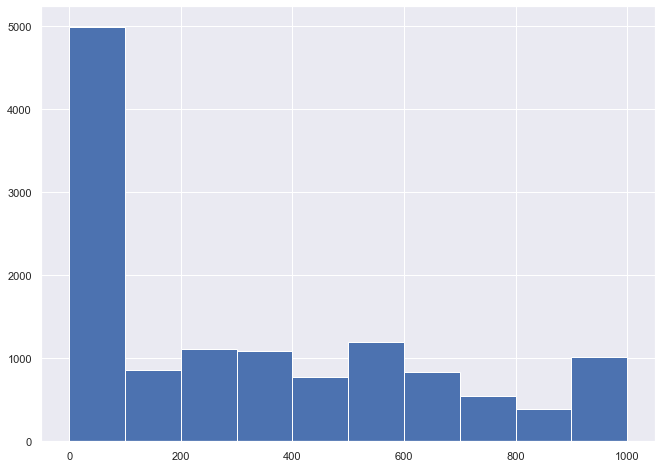

In [1749]:
df_users.attraction_coeff.hist();

In [1750]:
def rank_coeff(row): 
    if 0<=row['attraction_coeff'] <200:
        return 0
    elif 200<= row['attraction_coeff']<400:
        return 1
    elif 400<=row['attraction_coeff']<600:
        return 2
    elif 600<=row['attraction_coeff']<800:
        return 3
    else:
        return 4

In [1751]:
df_users['rank_coeff'] = df_users.apply(rank_coeff, axis=1)
#Разобъем юзеров на группы по коэффиценту привлекательности

## Объединение данных о юзерах и их транзакциях

In [1752]:
df_all = df_users.merge(df1,on=['uid','country'], how = 'left').fillna(0)
#Объединение данных о юзерах и их транзакциях, удаление нулей.

In [1753]:
df_all.head(5) #посмотрим на объединение данных

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,quantity_week,continent,age_group,rank_count,rank_coeff,joined_at,paid_at,revenue,payment_id,product_typeset
0,892319115,25,435,0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,...,1,north_america,young,1000,2,0,0,0.0,0.0,0
1,891248523,29,500,0,United States of America,"[1, 2]",1,26,32,12,...,1,north_america,young,100,2,0,0,0.0,0.0,0
2,891670932,33,800,0,France,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 16]",1,30,36,5,...,2,europe,norm,10,4,0,0,0.0,0.0,0
3,891060786,26,0,0,Argentina,"[1, 2, 3, 4, 5]",1,23,29,0,...,1,south_america,young,0,0,0,0,0.0,0.0,0
4,892006554,35,294,0,United States of America,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19]",1,30,40,17,...,2,north_america,norm,100,1,0,0,0.0,0.0,0


# Расчет ARPU и конверсии

конверсия в любую покупку

In [1754]:
df_ctr = df_all.loc[df_all['total_revenue'] != 0].groupby('group', as_index=False).uid.count()

In [1755]:
df_ctr['CTR'] = 100*df_all.loc[df_all['total_revenue'] != 0]\
                          .groupby('group', as_index=False)\
                          .uid.count().uid\
                          /df_all.groupby('group', as_index=False)\
                          .uid.count().uid

конверсия в платную подписку

In [1756]:
df_ctr['CTR_premium'] = 100*df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
                                  .groupby('group', as_index=False)\
                                  .agg({'uid':'count'})\
                                  .uid\
                                  /df_all\
                                  .groupby('group', as_index=False)\
                                  .uid.count().uid

конверсия в пробную подписку

In [1757]:
df_ctr['CTR_trial_premium'] =  100*df_all.query('product_typeset == "trial_premium"')\
                                  .groupby('group', as_index=False)\
                                  .agg({'uid':'count'})\
                                  .uid\
                                  /df_all\
                                  .groupby('group', as_index=False)\
                                  .uid\
                                  .count()\
                                  .uid

ARPU в любую покупку

In [1758]:
 df_ctr['arpu_all'] = df_all.groupby('group', as_index=False)\
                            .agg({'total_revenue':'sum'})\
                            .total_revenue\
                            /df_all.groupby('group', as_index=False)\
                            .agg({'uid':'count'})\
                            .uid

ARPU в premium

In [1759]:
df_ctr['arpu_no_trial'] = df_all.query('(is_premium == 1)and(total_revenue>0)')\
                            .groupby('group', as_index=False)\
                            .agg({'total_revenue':'sum'})\
                            .total_revenue/df_all\
                            .groupby('group', as_index=False)\
                            .agg({'uid':'count'})\
                            .uid

ARPU в пробный премиум

In [1760]:
df_ctr['arpu_trial'] = df_all.query('product_typeset == "trial_premium"')\
                            .groupby('group', as_index=False)\
                            .agg({'total_revenue':'sum'})\
                            .total_revenue/df_all\
                            .groupby('group', as_index=False)\
                            .agg({'uid':'count'})\
                            .uid

In [1761]:
df_ctr

,group,uid,CTR,CTR_premium,CTR_trial_premium,arpu_all,arpu_no_trial,arpu_trial
0,A1,187,4.345805,3.532419,1.092261,578.359517,519.577039,136.129909
1,A2,182,4.314841,3.437648,1.066856,442.311285,394.869606,144.981745
2,B1,144,3.367633,2.829747,1.005613,533.617166,493.820627,158.511225


# А/А тестирование двух контрольных выборок

Проверим наши контрольные группы на репрезентативность по долям и дисперсии. Сплитовалка не должна отдавать приоритет ни 
одной из группе по какому-либо признаку.

In [1762]:
df_all.groupby('group',as_index=False)\
      .agg({'uid':'count','gender':'sum'})
#посмотрим сколько в каждой группе мужчин,юзеров

,group,uid,gender
0,A1,4303,4121
1,A2,4218,4028
2,B1,4276,4079


In [1763]:
df_all.groupby(['group','country'],as_index=False)\
      .agg({'uid':'count'})\
      .pivot_table(index='country',columns='group',values ='uid')\
      .head(30)\
      .reset_index()
#посмотрим равномерное ли распределение юзеров по странам из разных групп 

group,country,A1,A2,B1
0,Algeria,2.0,NaN,2.0
1,Argentina,388.0,392.0,395.0
2,Australia,50.0,51.0,62.0
3,Azerbaijan,NaN,NaN,1.0
4,Belgium,107.0,90.0,91.0
5,Bolivia,NaN,NaN,1.0
6,Brazil,NaN,NaN,1.0
7,Canada,134.0,133.0,134.0
8,Chile,285.0,284.0,269.0
9,Colombia,1.0,2.0,1.0


In [1764]:
data = df_all.groupby(['group','age'],as_index=False)\
             .agg({'uid':'count'})
#разобъем всех юзеров по возрасту и годам и посчитаем их кол-во

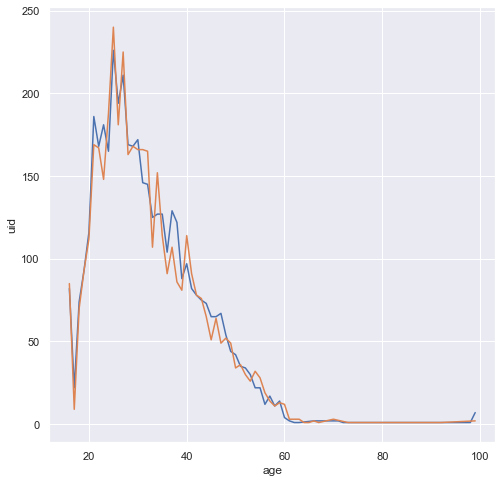

In [1765]:
plt.figure(figsize=(8,8))
sns.lineplot(x='age', y='uid', data=data.loc[data['group'] == 'A1'])
sns.lineplot(x='age', y='uid', data=data.loc[data['group'] == 'A2'])
sns.despine;
# посмотрим одиннаковое ли распредение юзеров по годам 

In [1766]:
df_all.groupby(['group','quantity_week'],as_index=False).agg({'uid':'count'})\
      .pivot_table(index='quantity_week',columns='group',values ='uid')\
      .reset_index()
#посмотри одинаковое распределение юзеров по посещаемости

group,quantity_week,A1,A2,B1
0,1,3371,3339,3359
1,2,533,531,560
2,3,275,232,238
3,4,124,116,119


In [1767]:
df_all.groupby(['group','rank_count'],as_index=False).agg({'uid':'count'})\
      .pivot_table(index='rank_count',columns='group',values ='uid')\
      .reset_index()
#посмотри одинаковое распределение юзеров по популярности

group,rank_count,A1,A2,B1
0,0,882,861,868
1,10,1805,1805,1777
2,100,1285,1263,1300
3,1000,331,289,331


Выдвигаем нулевую гипотезу о равенстве средней прибыли юзеров двух наших выборок.

  0%|          | 0/1000 [00:00<?, ?it/s]

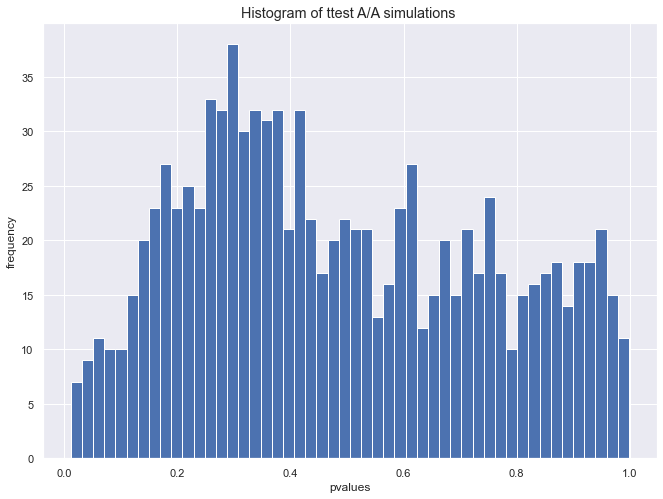

0.016

In [1768]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_all.loc[df_all['group']=='A1']['total_revenue'].sample(n_s, replace = False).values
    s2 = df_all.loc[df_all['group']=='A2']['total_revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

 Убедиться в корректности системы сплитования можно путём двухэтапной проверки: 
  1. Честное деление пользователей между группами
  2. Проверка FPR с помощью бизнес-метрик
  
 В системе сплитованя не наблюдается приоритета ни по одному параметру:
 - году рождения
 - количество юзеров в группе
 - половому признаку
 - территориальному признаку
 - популярности
 - посещаемости
 
 В нашем тесте FPR <0.05, найденный при помощи статистического оценщика (ttest), что говорит нам о том, что сплитовалка
работает корректно.

# А/B тестирование

## Тест Шапиро-Уилка на нормальность распределения

<AxesSubplot:>

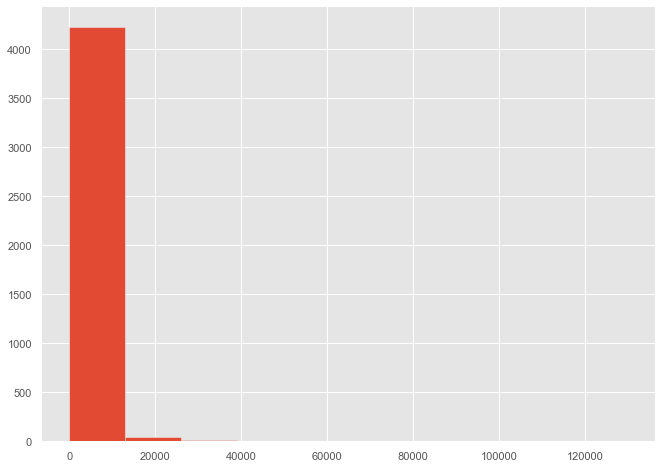

In [1769]:
df_all.loc[df_all['group']=='B1']['total_revenue'].hist() #посмотрим распределение трат юзеров группы B1

<AxesSubplot:>

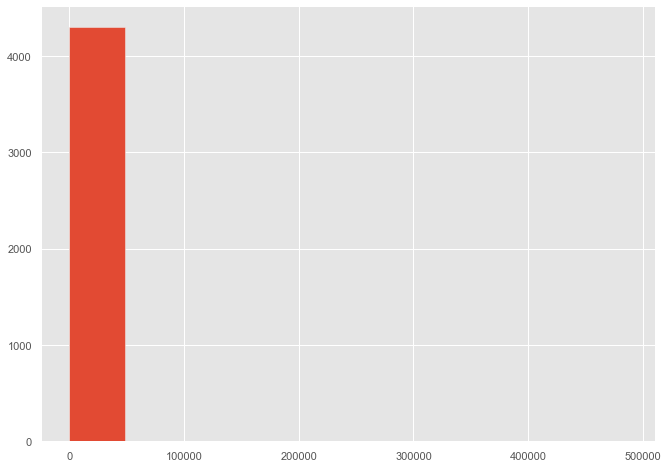

In [1770]:
df_all.loc[df_all['group']=='A1']['total_revenue'].hist()#посмотрим распределение трат юзеров группы А1

<AxesSubplot:>

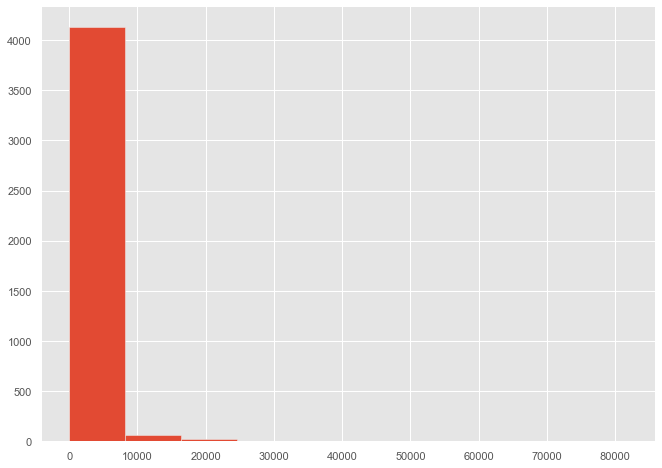

In [1771]:
df_all.loc[df_all['group']=='A2']['total_revenue'].hist()#посмотрим распределение трат юзеров группы А2

Перед тем как определиться с выбором статистического критерияи проверим гипотезы связанные с распределением и дисперсией

In [1772]:
test1 = df_all.loc[(df_all['group']=="A1")].total_revenue
test2 = df_all.loc[(df_all['group']=="A2")].total_revenue
test3 = df_all.loc[(df_all['group']=="B1")].total_revenue
#возьмем юзеров из группы А и С

Нулевая гипотеза звучит так: наша выборка взята из генеральной совокупности, где распределение соотвествует нормальному. 

In [1773]:
 sps.shapiro(test1.sample(150, random_state=17))

ShapiroResult(statistic=0.23264998197555542, pvalue=1.1778753346791097e-24)

In [1774]:
 sps.shapiro(test2.sample(150, random_state=17))

ShapiroResult(statistic=0.10029631853103638, pvalue=2.7078208321023125e-26)

In [1775]:
 sps.shapiro(test3.sample(150, random_state=17))

ShapiroResult(statistic=0.13767045736312866, pvalue=7.498502543436355e-26)

Так как pvalue меньше 0.05, это нам говорит о том, что можно отклонить нулевую гипотезу о том, что наше распределение не отличается от нормального. Т.е распределение отличается от нормального.

Нулевая гипотеза для теста Левена состоит в том, что дисперсия между группами одинакова.

In [1776]:
sps.levene(test1,test2,test3)

LeveneResult(statistic=0.6718379407764674, pvalue=0.5107869702180676)

Pvalue больше 0.05 , значит мы не можим отклонить нулевую гипотезу, следовательно наши дисперсия  у трех выборок одинакова. 

## Boxplot для тестовой и контрольной группы

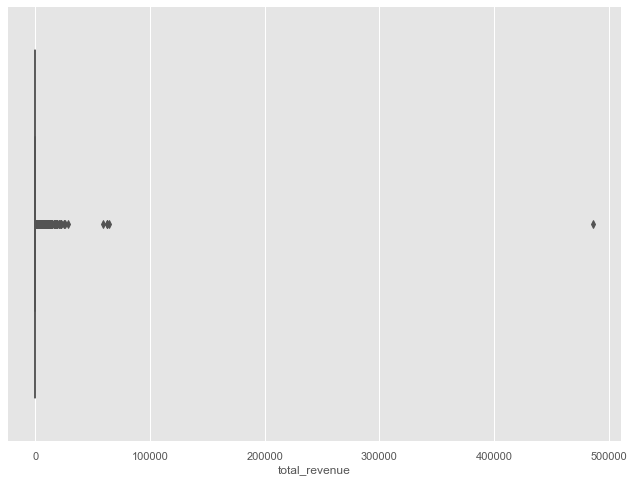

In [1777]:
sns.boxplot(df_all.loc[(df_all['group']=="A1")].total_revenue); # посмотрим на выбросы в группе А

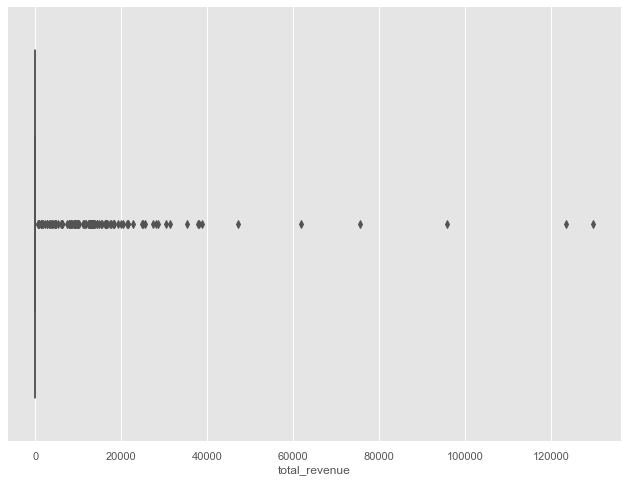

In [1778]:
sns.boxplot(df_all.loc[(df_all['group']=="B1")].total_revenue); # посмотрим на выбросы в группе С

In [1779]:
test1 = df_all.loc[(df_all['total_revenue']>0)&(df_all['group']=="A1")].total_revenue
test2 = df_all.loc[(df_all['total_revenue']>0)&(df_all['group']=="B1")].total_revenue
test3 = df_all.loc[(df_all['total_revenue']>0)&(df_all['group']=="A2")].total_revenue

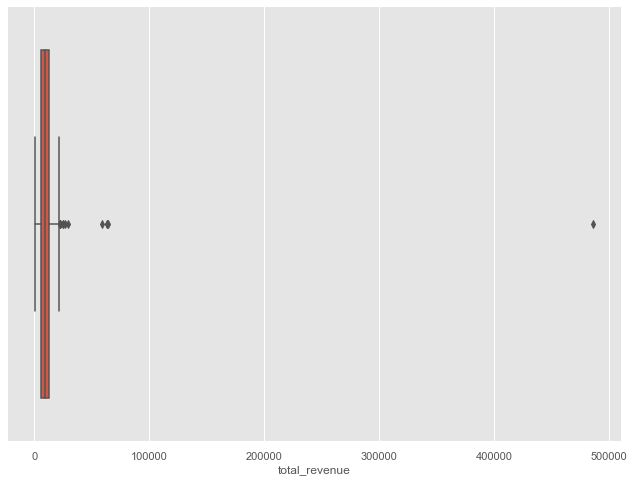

In [1780]:
sns.boxplot(x=test1); # посмотрим на выбросы в группе А без учета 0 покупок

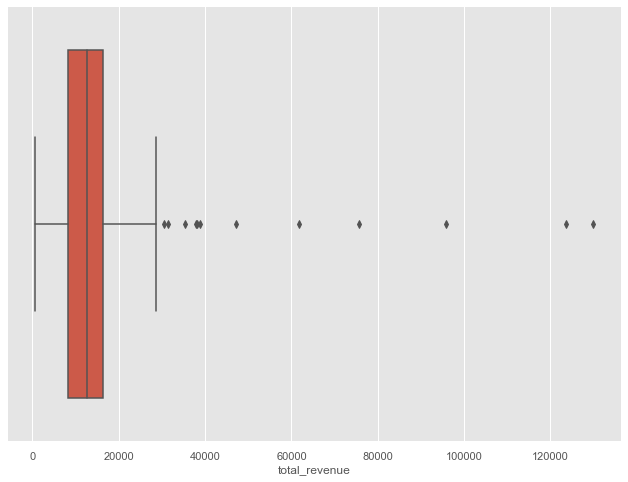

In [1781]:
sns.boxplot(x=test2);# посмотрим на выбросы в группе С без учета 0 покупок

Возьмем случайную подвыборку из нашей выборки, посчитаем среднее, занесем это значение в список, и повторим 
эту операцию 10000, тем самым мы получим распределение средних, предполагая что это распределение совпадает с
распределением среднего геренеральной совокупности. Нанесем все это на график и сравним его с идеальным 
нормальным распределением.

In [1782]:
test1 = df_all.loc[(df_all['group']=="A1")].total_revenue
test2 = df_all.loc[(df_all['group']=="A2")].total_revenue
test3 = df_all.loc[(df_all['group']=="B1")].total_revenue

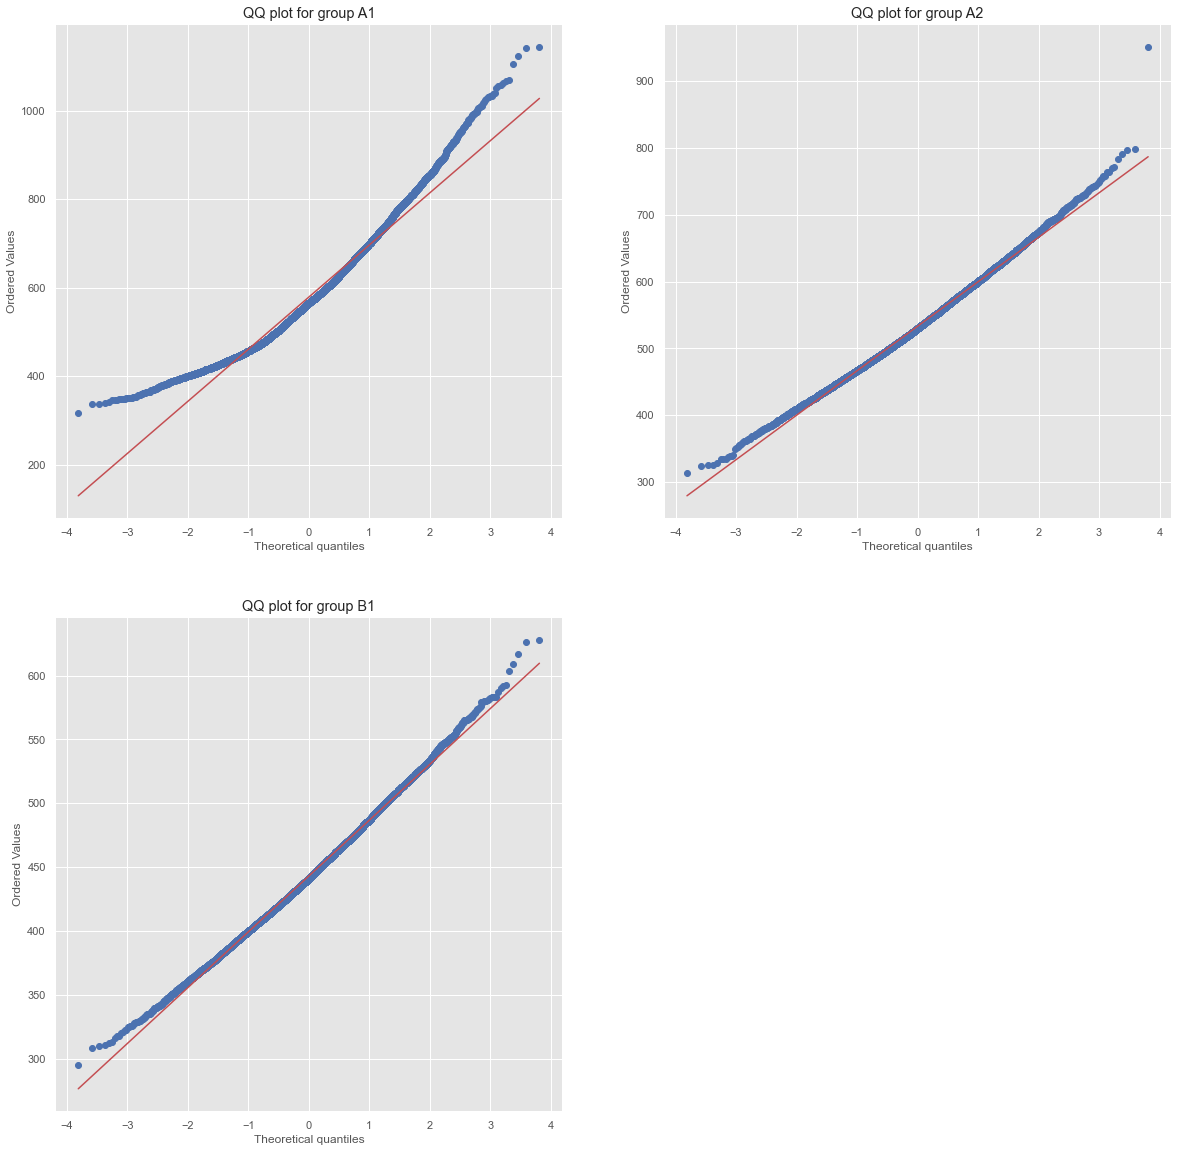

In [1783]:
sample_means_A1=[]
sample_means_A2=[]
sample_means_B1=[]

for i in range(10000):
    sample_A1 = test1.sample(frac=1, replace=True)
    sample_A2 = test3.sample(frac=1, replace=True)
    sample_B1 = test2.sample(frac=1, replace=True)
    sample_means_A1.append(sample_A1.mean())
    sample_means_B1.append(sample_B1.mean())
    sample_means_A2.append(sample_A2.mean())
    

pylab.figure(figsize=(20,20))
ax1 = pylab.subplot(2,2,1)
stats.probplot(sample_means_A1, dist="norm", plot=pylab)
ax1.set_title("QQ plot for group A1")
ax2 = pylab.subplot(2,2,2)
stats.probplot(sample_means_A2, dist="norm", plot=pylab)
ax2.set_title("QQ plot for group A2")
ax3 = pylab.subplot(2,2,3)
stats.probplot(sample_means_B1, dist="norm", plot=pylab)
ax3.set_title("QQ plot for group B1")
pylab.show()


In [1784]:
test1 = df_all.loc[(df_all['group']=="A1")&(df_all['is_premium']==1)&(df_all['uid']!=892333905)].total_revenue

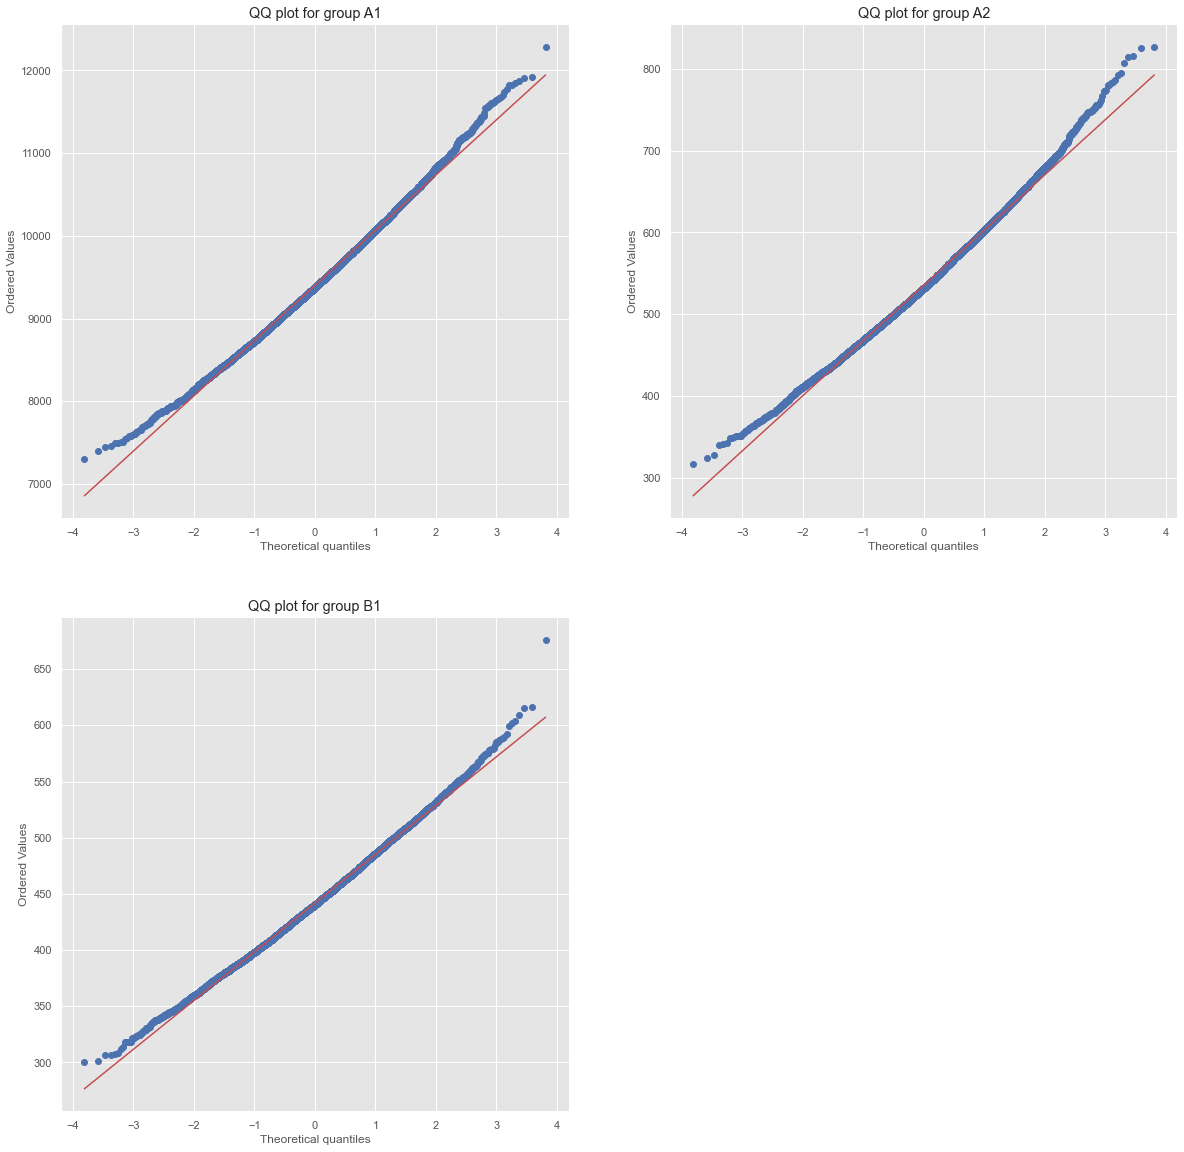

In [1785]:
sample_means_A1=[]
sample_means_A2=[]
sample_means_B1=[]

for i in range(10000):
    sample_A1 = test1.sample(frac=1, replace=True)
    sample_A2 = test3.sample(frac=1, replace=True)
    sample_B1 = test2.sample(frac=1, replace=True)
    sample_means_A1.append(sample_A1.mean())
    sample_means_B1.append(sample_B1.mean())
    sample_means_A2.append(sample_A2.mean())
    

pylab.figure(figsize=(20,20))
ax1 = pylab.subplot(2,2,1)
stats.probplot(sample_means_A1, dist="norm", plot=pylab)
ax1.set_title("QQ plot for group A1")
ax2 = pylab.subplot(2,2,2)
stats.probplot(sample_means_A2, dist="norm", plot=pylab)
ax2.set_title("QQ plot for group A2")
ax3 = pylab.subplot(2,2,3)
stats.probplot(sample_means_B1, dist="norm", plot=pylab)
ax3.set_title("QQ plot for group B1")
pylab.show()

Вывод:
 - В оригинальной выборки очень много значений выручки =0, после удаления их все равно остается много выбросов, которые 
могут нам помешать в трактовке статистического критерия.
 - При рассмотрения qq plot, можно сделать вывод, что распределение средних значений total_revenue для групп В1 и А2 похоже на 
 нормальное распределение, а вот распределение А1 сильно отличается от нормального. При удалении всего одного uid =892333905
 распредление очень похоже на нормальное.

Обоснуем выбор критерия, которым будем пользоваться:

Требования к Т-критерий Стьюдента:
- дисперсии внутри групп должна быть одинаковы. Тест Левена нам показал гомогенность дисперсии.
- нормальным должно быть распределение среднего значения метрики.  
- отсутвие огромнейших выбросов (отсутвие большого количества выбросов).

Манна-Уитни:   
    Плюсы критерия:
- критерий не требует каких-либо дополнительных предположений о распределении данных.
- поскольку он работает с рейтингом (выручка), а не с самой выручкой, он более устойчив к выбросам
Минусы:
- даже на идеальных данных менее мощный чем t-test (на 5%)
- критерий теряет силу, если в выборки много повторяющихся данных ( в нашем случае total_revenue =0)
- тяжело интерпретировать результат

Bootstrap:
     Плюсы:
- позволяет проверять гипотезы для любых параметров распределения (парцентиль,квантиль)
- при проверки статистических данных не опирается на теоритические распределения данных.
Наиболее подходящие способа это Т-критерий стьюдента и Bootstrap, воспользуемся ими обоими.

 
В ходе A/B тестирования я для начала проверю, общие метрики: 
- конверсию в покупку премиум подписки, 
- среднее значение трат юзеров (ARPU),
- конверсию в покупку премиум подписки для юзеров приносящие прибыль,
- среднее значение трат юзеров (ARPU) приобревшие премиум подписку
Так как изменение стоимости премиум-подписки через две новые платежные системы  могут либо увеличить или уменьшить СR, 
в следствии чего должна и хотелось бы зафиксировать статически изменния ARPU, так как именно это интерсно бизнесу.

## Проверка равенства конверсии

In [1786]:
CR_A1 = df_all.query('(group == "A1")')['is_premium']
CR_A2 = df_all.query('(group == "A2")')['is_premium']
CR_B1 = df_all.query('(group == "B1")')['is_premium']
control_A1_A2 = pd.concat([CR_A1,CR_A2])

In [1787]:
cross_table = pd.crosstab(df_all.is_premium, df_all.group)

In [1788]:
cross_table['A1_A2'] = cross_table['A1']+cross_table['A2']

In [1789]:
cross_table

group,A1,A2,B1,A1_A2
is_premium,,,,
0,4116,4031,4122,8147
1,187,187,154,374


Выдвигаем гипотезу о том, что у трех групп А1,А2,В1 имеется связь по конверсии в премиальную подписку. 
Воспользуемся критерием хи-квадратом, так как выполняются 2 условия необходимые для этого критерия:
   - наблюдения независимы
   - количество наблюдений в каждой ячейки больше 5

In [1790]:
g, p, dof, expctd = chi2_contingency([cross_table[['A1','B1']]],correction=False)
print('Значение уровня значимости при сравнении группы А1 и В1 : ', p)
g, p, dof, expctd = chi2_contingency([cross_table[['A2','B1']]],correction=False)
print('Значение уровня значимости при сравнении группы А2 и В1 : ', p)
g, p, dof, expctd = chi2_contingency([cross_table[['A1_A2','B1']]],correction=False)
print('Значение уровня значимости при сравнении группы А1_A2 и В1 : ', p)

Значение уровня значимости при сравнении группы А1 и В1 :  0.07767100357571018
Значение уровня значимости при сравнении группы А2 и В1 :  0.050844699979264704
Значение уровня значимости при сравнении группы А1_A2 и В1 :  0.034585913088501785


Получаем, что А1,А2 зависимы с В1, но А1+А2 независимы, что очень подозрительно. Во первых значение P_value для А2 и В1
лежат на пограничном значений и малейшее изменение выборки, может изменить стат. вывод координально. Плюс есть
предположение, что такая ситуация может возникнуть в той ситуации когда нам не хватает данных о юзерах, чтобы обнаружить
стат. значимые изменения, а при увеличении выборки (А1+А2) наши изменения прокрашиваются и наш оценщик может это обнаружить.
Либо мы имеем ошибку 2 рода, а наш стат. оценщик имеет слабую мощность.

Наше распределение биноминальное попробуем воспользоваться другим критерием: z-test  пропорции, для проверки наличие ошибки 2 
рода в предыдущем анализе. Нулевая гипотеза: нет различий в конверсии между группами А1,А3 и В1

In [1791]:
count = np.array([cross_table['A1'][1], cross_table['B1'][1]])
nobs = np.array([cross_table['A1'][0], cross_table['B1'][0]])
stat, pval = proportions_ztest(count, nobs)
print('Значение уровня значимости при сравнении группы А1 и В1 : ','{0:0.3f}'.format(pval))
count = np.array([cross_table['A2'][1], cross_table['B1'][1]])
nobs = np.array([cross_table['A2'][0], cross_table['B1'][0]])
stat, pval = proportions_ztest(count, nobs)
print('Значение уровня значимости при сравнении группы А2 и В1 : ','{0:0.3f}'.format(pval))
count = np.array([cross_table['A1_A2'][1], cross_table['B1'][1]])
nobs = np.array([cross_table['A1_A2'][0], cross_table['B1'][0]])
stat, pval = proportions_ztest(count, nobs)
print('Значение уровня значимости при сравнении группы А1_A2 и В1 : ','{0:0.3f}'.format(pval))

Значение уровня значимости при сравнении группы А1 и В1 :  0.066
Значение уровня значимости при сравнении группы А2 и В1 :  0.042
Значение уровня значимости при сравнении группы А1_A2 и В1 :  0.028


Получаем, что в группе А2 и B1, как в A1_A2 и В1 есть cтат. значимые отличия. Что как раз подтверждет предположение о том, что
критерий хи-квадрат дает ошибку 2 рода, а при сравнении А1 и В1 нам все-таки не хватает количесвто данных для того чтобы 
зафиксировать маленькое изменение в конверсии.

Для контрольной проверки воспользуемся bootstrap. Нулевая гипотеза звучит так: разница в среднем значений конверсии между 
сравниваемыми группами нету.

In [1792]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    test1, # числовые значения первой выборки
    test2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(test1), len(test2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = test1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = test2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

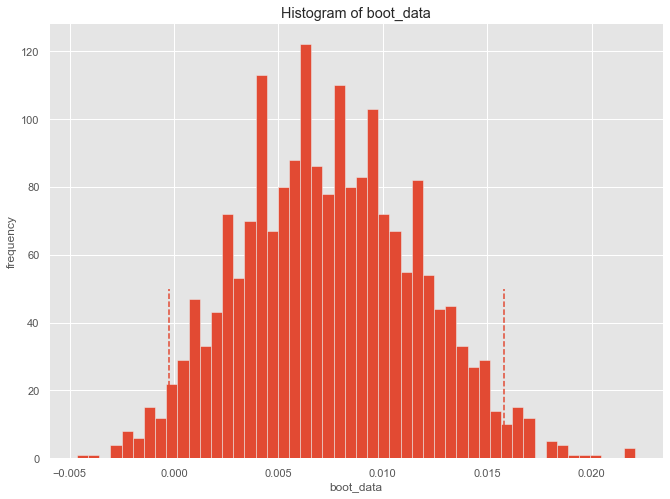

FPR для А1 (контрольной) / B1 (тест): 0.07842223831335365


  0%|          | 0/2000 [00:00<?, ?it/s]

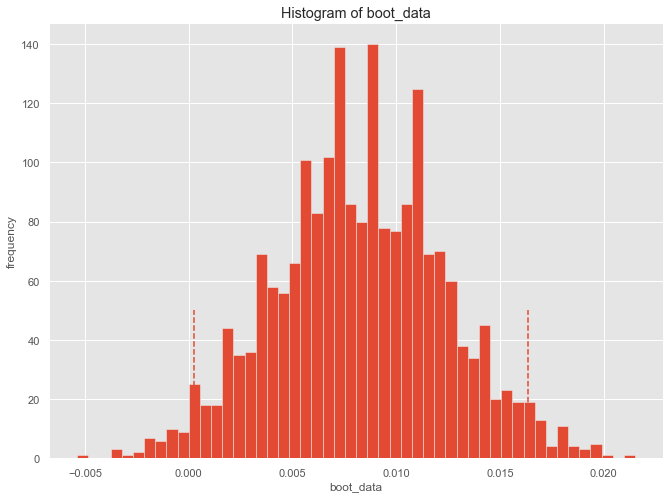

FPR для А2 (контрольной) / B1 (тест): 0.04320388286748541


  0%|          | 0/2000 [00:00<?, ?it/s]

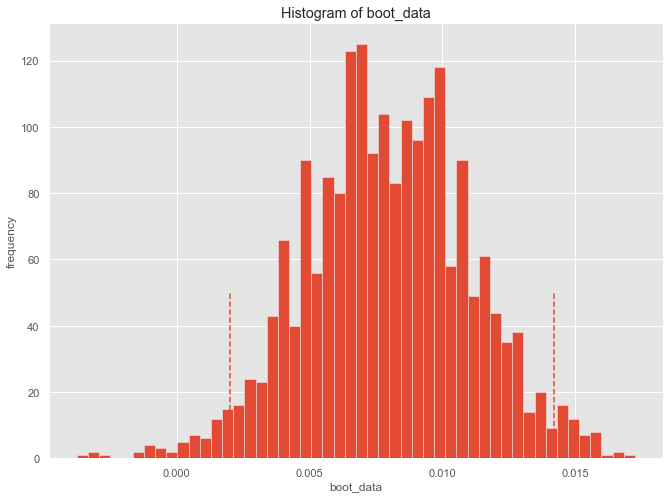

FPR для А1_A2 (контрольной) / B1 (тест): 0.01006545948796305


In [1793]:
booted_data = get_bootstrap(CR_A1, CR_B1, boot_it = 2000);
print('FPR для А1 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(CR_A2, CR_B1, boot_it = 2000);
print('FPR для А2 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(control_A1_A2, CR_B1, boot_it = 2000);
print('FPR для А1_A2 (контрольной) / B1 (тест):',booted_data["p_value"])

Мы получили абсолютно тот же результат, что и при использовании z-test пропорции. Т.е. конверсии между группами А1 и В1 стат.
значимо не различаются, А2 и В1, А1_А2 и В1 - стат.значимо различаются.
На основании 3 критериев можно сделать вывод:
Конверсия в группах А1 и А2 стат. значимо различаются, только для группы А2 эти различия сильнее, поэтому наши критерии могут
прокрасить это изменения, а вот в группе А1 различия столь не значительны, что при таком количестве данных о юзерах различия 
не детектируются.

## Равенство средних значений ARPU

Посмотрим статистически ли значимо изменение АRPU в группах.
Проверим нулевую гипотезу о том, что группах среднее значение выручки в группах одинаково.

In [1794]:
A1 = df_all.loc[(df_all['group']=="A1")].total_revenue
A2 = df_all.loc[(df_all['group']=="A2")].total_revenue
B1 = df_all.loc[(df_all['group']=="B1")].total_revenue
control_A1_A2 = pd.concat([A1,A2]) # объединение группы А и В

  0%|          | 0/1000 [00:00<?, ?it/s]

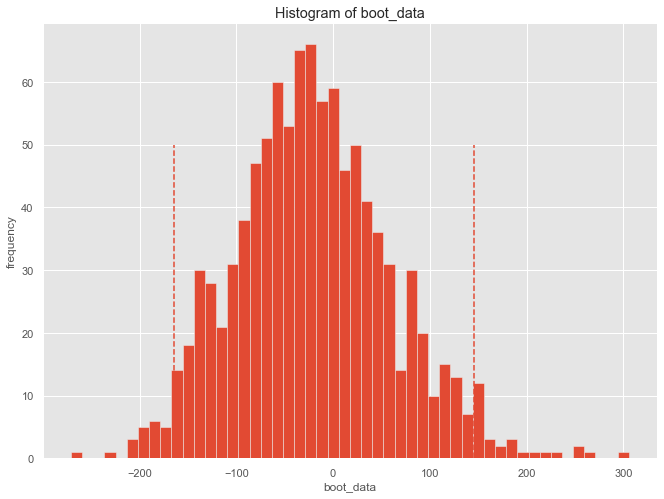

FPR для А1,A2 (контрольной) / B1 (тест): 0.7892565201078962


  0%|          | 0/1000 [00:00<?, ?it/s]

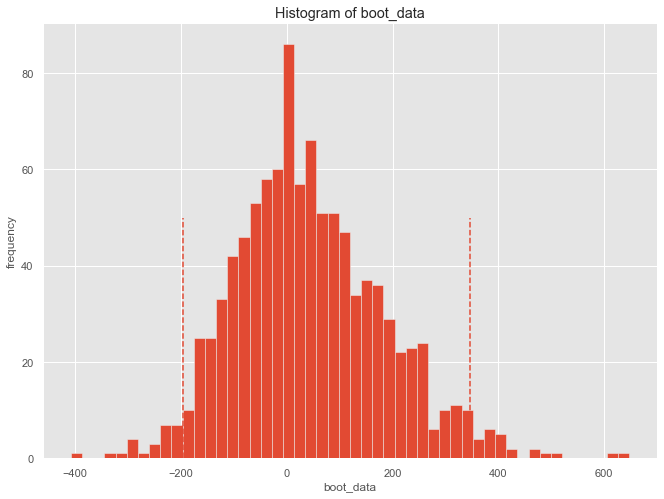

FPR для А1 (контрольной) / B1 (тест): 0.7622047618526527


  0%|          | 0/1000 [00:00<?, ?it/s]

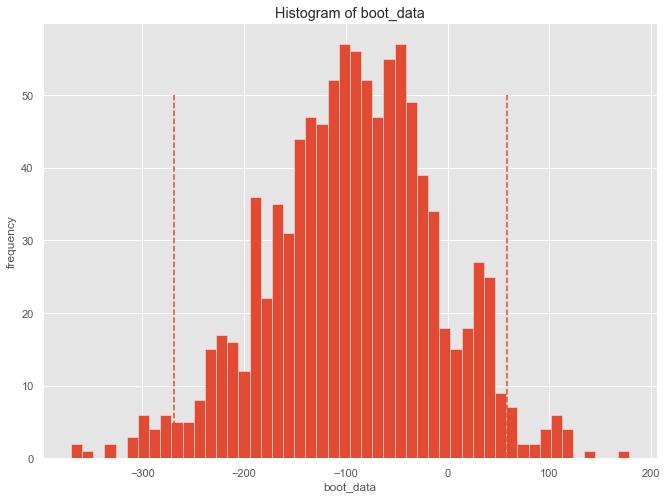

FPR для A2 (контрольной) / B1 (тест): 0.264065522179149


In [1795]:
booted_data = get_bootstrap(control_A1_A2, B1, boot_it = 1000);
print('FPR для А1,A2 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A1, B1, boot_it = 1000);
print('FPR для А1 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A2, B1, boot_it = 1000);
print('FPR для A2 (контрольной) / B1 (тест):',booted_data["p_value"])

FPR>0.05, соответвенно нельзя отклонить нулевую гипотезу, а это значит средняя выручка для юзеров 
статистически не изменилась.

## Равенство средних значений ARPU в премиум

Выдвигаем нулевую гипотезу о равенстве средних значений АRPU юзеров купивших премиальную подписку.

In [1796]:
A1 = df_all.loc[(df_all['group']=="A1")&(df_all['is_premium']==1)].total_revenue
A2 = df_all.loc[(df_all['group']=="A2")&(df_all['is_premium']==1)].total_revenue
B1 = df_all.loc[(df_all['group']=="B1")&(df_all['is_premium']==1)].total_revenue

In [1797]:
control_A1_A2 = pd.concat([A1,A2]) # объединение группы А и В

  0%|          | 0/1000 [00:00<?, ?it/s]

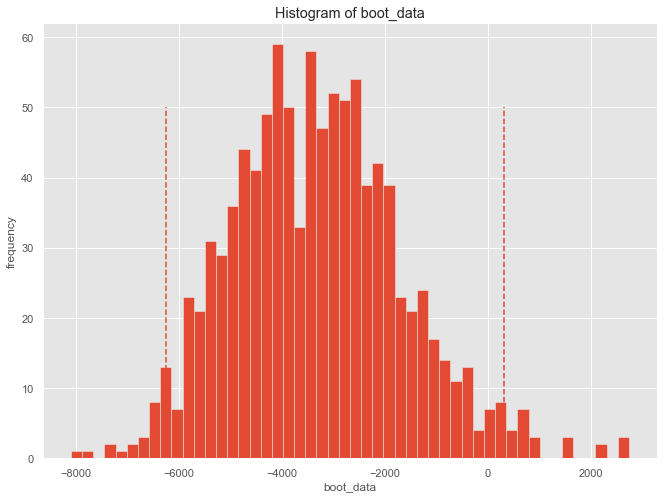

FPR для А1,A2 (контрольной) / B1 (тест): 0.0442657513155309


  0%|          | 0/1000 [00:00<?, ?it/s]

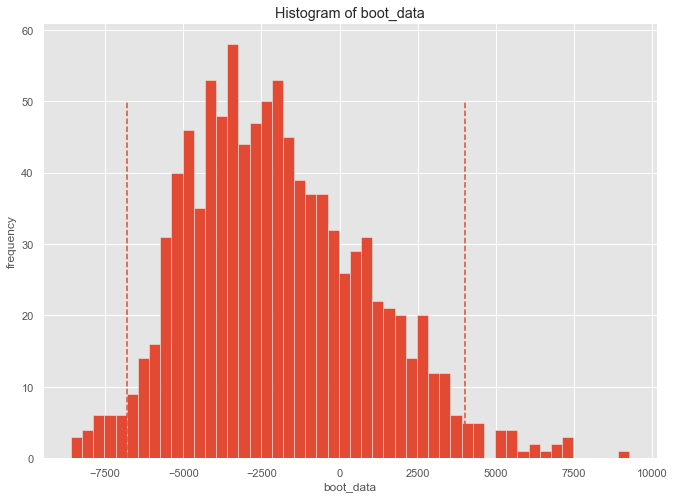

FPR для А1 (контрольной) / B1 (тест): 0.49013170576535603


  0%|          | 0/1000 [00:00<?, ?it/s]

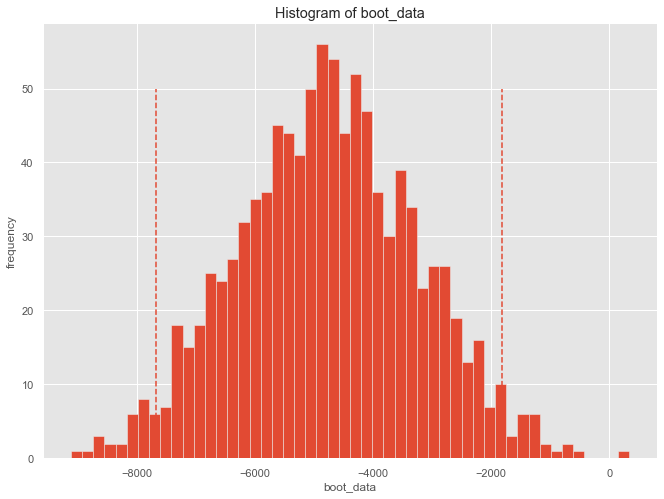

FPR для A2 (контрольной) / B1 (тест): 0.0016333760950278699


In [1798]:
booted_data = get_bootstrap(control_A1_A2, B1, boot_it = 1000);
print('FPR для А1,A2 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A1, B1, boot_it = 1000);
print('FPR для А1 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A2, B1, boot_it = 1000);
print('FPR для A2 (контрольной) / B1 (тест):',booted_data["p_value"])

Наблюдаем очень интересные результаты: 
   - FPR>0.05 когда мы сравниваем группу А1 с В1, группу А1 и В1, что нам говорит о том, не можем отвергнуть нулевую гипотезу,
    о том что средние значения ARPU будут отличаться, т.е. наши изменения не стат. значимы.
   - FPR<0.05 когда мы сравниваем А2 с В1, то значения стат. значимы.
Из чего можно сделать вывод, что А1 и А2 должны стат. различаться, но в то же время мы проводили А/A тест, который нам показал
обратное. Такое могло произойти, из-за того что, средняя выручка с клиентов купившие премиум стат. различаются в группах А1 и 
А2. Либо в группах есть выбросы и они перетягивают на себя среднее значение.Проверим, изменится ли
стат. значимость, если из выборки убрать юзера uid=892333905, так как его total_revenue в 4 раза больше ближайшего конкурента

##  Равенство средних значений ARPU без единственного выброса

Выдвигаем нулевую гипотезу о равенстве средних значений АRPU юзеров купивших премиальную подписку.

In [1799]:
A1 = df_all.loc[(df_all['group']=="A1")&(df_all['is_premium']==1)&(df_all['uid']!=892333905)].total_revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

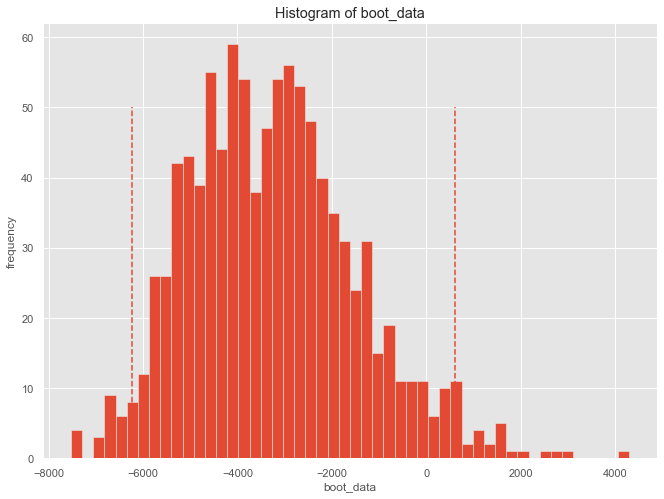

FPR для А1,A2 (контрольной) / B1 (тест): 0.06500675302861811


  0%|          | 0/1000 [00:00<?, ?it/s]

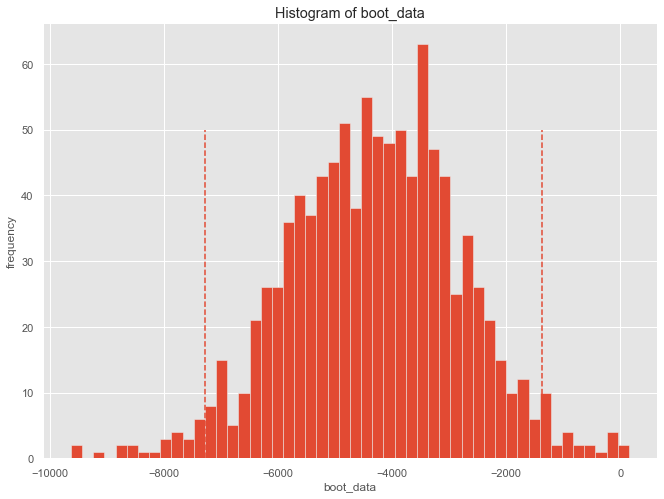

FPR для А1 (контрольной) / B1 (тест): 0.004190455872439331


  0%|          | 0/1000 [00:00<?, ?it/s]

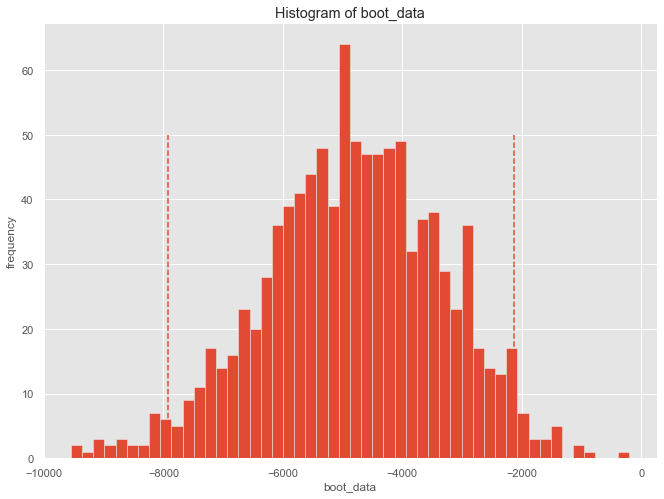

FPR для A2 (контрольной) / B1 (тест): 0.0012119161181143197


In [1800]:
booted_data = get_bootstrap(control_A1_A2, B1, boot_it = 1000);
print('FPR для А1,A2 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A1, B1, boot_it = 1000);
print('FPR для А1 (контрольной) / B1 (тест):',booted_data["p_value"])
booted_data = get_bootstrap(A2, B1, boot_it = 1000);
print('FPR для A2 (контрольной) / B1 (тест):',booted_data["p_value"])

 FPR<0.05, отклоняем нулевую теорию,изменеия  для всех расчетов стат. значимы.

##  Проверка равенства конверсии в премиум и совершавшие покупки

In [1801]:
df_all.query('product_typeset == "premium_no_trial"').is_premium.sum()
#посчитаем количество юзеров у которых есть запись о том, что они провели транзакцию о покупки премиума

213

In [1802]:
df_all.query('is_premium == 1').is_premium.sum()
#посчитаем количество юзеров, которые на данный момент обладают премиум подпиской

528

In [1803]:
df_all.query('(is_premium == 1)and(product_typeset != "premium_no_trial")')\
.drop(columns=['gender','age_filter_start','continent','rank_count','age_group','rank_coeff','age','quantity_week',
              'age_filter_end','revenue','attraction_coeff','views_count']).head(5)
# посмотрим на юзеров, которые имееют премиум подписку и у них есть запись в транзакциях,что они проплатили премиум подписку
# удалим много столбцов, для удобства

,uid,coins,country,visit_days,was_premium,is_premium,total_revenue,group,was_premiums,joined_at,paid_at,payment_id,product_typeset
64,891100086,0,France,[0],1.0,1,0,A1,1,0,0,0.0,0
140,891242025,0,United States of America,"[1, 2, 3, 5]",1.0,1,0,A1,1,0,0,0.0,0
328,892037091,0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1,12727,A1,1,2017-10-22,2017-10-29,147.0,trial_premium
360,891462408,0,United States of America,"[1, 2, 3, 4, 5]",1.0,1,9087,A1,1,2017-03-11,2017-10-11,147.0,trial_premium
362,891216537,0,United States of America,"[4, 5]",1.0,1,0,A1,1,0,0,0.0,0


Различие в количестве совершенных транзакции по покупке премиума и количества юзеров обладающих премиум подпиской обусловлено
тем, что у юзеров, которые имеют премиум подписка потеряна информация о их транзакциях. Поэтому для проверки 
статистических отличий среднии конверсий тестовой группы от контрольной будет брать юзеров, которые принесли доход приложению,
а также являются обладателями премиум подпиской. Отсекли группу юзеров, которые имеют премиум подписку, но total_revenue=0,
так как эти юзеры не приносит нам доход и учитывать их подсчета нету смысла.

In [1804]:
CR_A1 = df_all.query('(total_revenue >0)and(group == "A1")')['is_premium']
CR_A2 = df_all.query('(total_revenue >0)and(group == "A2")')['is_premium']
CR_B1 = df_all.query('(total_revenue >0)and(group == "B1")')['is_premium']
#возьмем столбец говорящий о том в данный момент юзер имеет ли премиум подписку, предварительно отсортировав юзеров по группам
# и то что юзер приносит приложению доход

In [1805]:
control_A1_A2 = pd.concat([CR_A1,CR_A2])

  0%|          | 0/2000 [00:00<?, ?it/s]

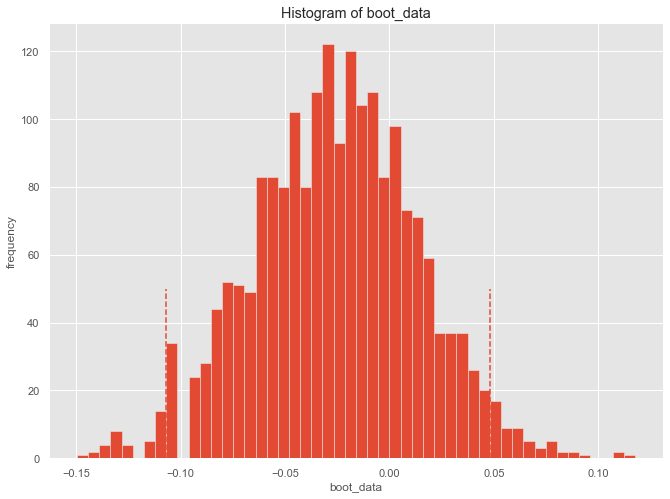

In [1806]:
booted_data = get_bootstrap(CR_A1, CR_B1, boot_it = 2000);

In [1807]:
booted_data["p_value"]

0.4660056377518904

  0%|          | 0/2000 [00:00<?, ?it/s]

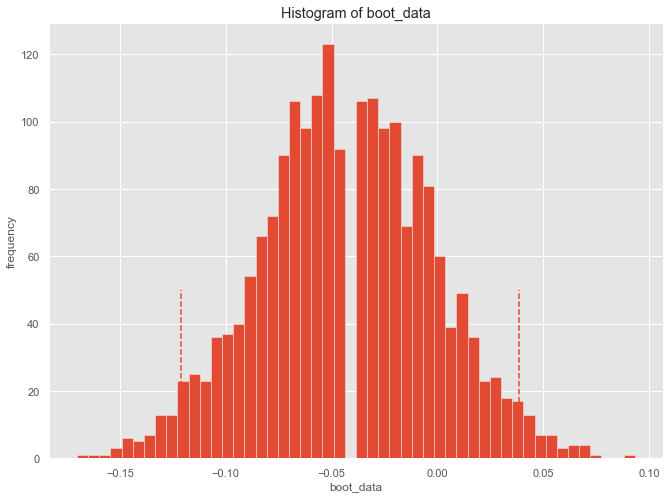

In [1808]:
booted_data = get_bootstrap(CR_A2, CR_B1, boot_it = 2000);

In [1809]:
booted_data["p_value"]

0.28608604461258436

  0%|          | 0/2000 [00:00<?, ?it/s]

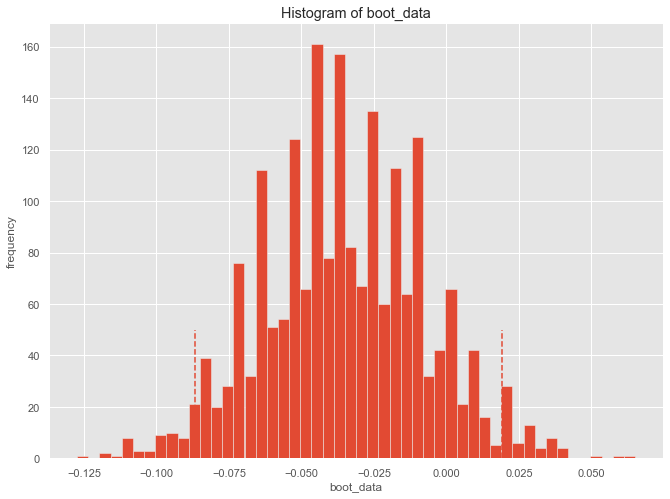

In [1810]:
booted_data = get_bootstrap(control_A1_A2, CR_B1, boot_it = 2000);

In [1811]:
booted_data["p_value"]

0.20148453535468314

Значение FPR >0.05 значит не можем отвергнуть нулевую гипотезу, о том что средние значения конверсии будут отличаться, т.е. наши изменения не стат. значимы.

# Анализ групп пользователей

## Проверка юзеров разбитых по континентам

In [1812]:
df_all = df_all.query('uid != 892333905') # удаляю юзера из общего датафрейма

In [1813]:
continent = df_all.loc[df_all['is_premium'] == 1]\
              .groupby('continent',as_index = False)\
              .agg({'uid':'count'})\
              .continent.unique().tolist()
#формируем список континетов
group = df_all.group.unique().tolist() # создаем список групп (A1,A2,B1)
continent.remove('oceanic') #удалим континент, рассмотри его потом
group.remove('A2') #удалим группу A2, достаточно А и С

Создадим список чисел, для того чтобы потом посчитать p_value для каждого континетна
 - первое число - сколько человек приобрело премиальную подписку
 - второе число - сколько человек не приобрело премиальную подписку
 - и так для каждой группы А и С

In [1814]:
t = []
f = []
for i in continent:
    for j in group:
        k = df_all[(df_all['group'] == j)&(df_all['continent'] == i)\
                   &(df_all['is_premium'] == 1)&(df_all['total_revenue'])].count().uid
        k_no_buy = df_all[(df_all['group'] == j)&(df_all['continent'] == i)].count().uid - k
        g = [k,k_no_buy]
        f.append(g)

Считаем P-value для каждой континента

In [1815]:
k = 0
z = []
c = []
for i in f:
    z.append(i)
    k = k+1
    if k == 2:
        g, p, dof, expctd = chi2_contingency([z[0],z[1]],correction=False)
        c.append(p)
        z.pop(0)
        k = 0
        z.pop(0)
    else:
        pass

In [1816]:
p_value = pd.DataFrame(c, columns= ['P_value'])
p_value['comtinent'] = continent

In [1817]:
p_value

,P_value,comtinent
0,0.846075,asia
1,0.342093,europe
2,0.354544,north_america
3,0.112291,south_america


Вывод:
- Конверсия в покупку статистически  не изменилась для всех континентов, так как p-value > 0.05. Ближе всего к изменения это 
южная Америка. Такое может произойти из-за того, что на каждом континенте сильный разброс в покупательной способности юзеров. Например,
в Аргентине при повышении стоимости приложения все юзеры продолжили покупать приложения, а в остальных странах Перу,Чили,
Венесуэле это подорожание критически сказывается на покупки премиум, но за счет Аргенитны средняя конверсия выравнивается.
Следовательно, нужно рассматривать каждую страну в отдельности.

## Точный критерий фишера для континента Oceanic

Используем критерий Фишера потому что:
 - объем выборки маленький (так как меньше 5 нежелательно использовать Хи квадрат Пирсона)
 - тип данных категориальный

In [1818]:
oceanic_A1 = df_all[(df_all['group'] == "A1")\
                         &(df_all['continent'] == 'oceanic')\
                         &(df_all['is_premium'] == 1)\
                         &(df_all['total_revenue']>0)]\
                         .count().uid
#количество юзеров обладающие премиумом из группы А1 с континента океания

In [1819]:
oceanic_B1 = df_all[(df_all['group'] == "B1")\
                         &(df_all['continent'] == 'oceanic')\
                         &(df_all['is_premium'] == 1)\
                         &(df_all['total_revenue']>0)]\
                         .count().uid
#количество юзеров обладающие премиумом из группы B1 с континента океания

In [1820]:
oceanic_A1_no_buy = df_all[(df_all['group'] == "A1")\
                         &(df_all['continent'] == 'oceanic')]\
                         .count().uid\
                         - oceanic_A1 
#количество юзеров не имеющие премиумом из группы А1 с континента океания

In [1821]:
oceanic_B1_no_buy = df_all[(df_all['group'] == "B1")\
                         &(df_all['continent'] == 'oceanic')]\
                         .count().uid\
                         - oceanic_B1 
#количество юзеров не имеющие премиумом из группы С с континента океания

In [1822]:
t = np.array([[oceanic_A1,oceanic_A1_no_buy],[oceanic_B1,oceanic_B1_no_buy]])
#собираем все посчитанные значения в массив

In [1823]:
odd_ratio,p_value = stats.fisher_exact(t)
print(p_value)

0.6186984550914725


Вывод: 
- континент океаника, также не статистически не изменились. 

## Проверка юзеров разбитых по посещаемости приложения

Проверим, связано ли посещаемость приложения клиентом с конверсией в покупку премиума. Другими словами, если юзеры из группы А
заходили меньше 7 раз, то их конверсия такая же как юзеров из группы С, которые также посещали приложения 7 раз. Сатистически
ли разные эти отклонения

In [1824]:
df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
      .groupby(['quantity_week','group'],as_index = False)\
      .agg({'uid':'count'})\
      .pivot_table(index = 'quantity_week',columns = 'group' , values = 'uid' )\
      .reset_index()
# разобъем юзеров,которые имею премиум и приносят доход по группам и количествам посещенных недель

group,quantity_week,A1,A2,B1
0,1,76,71,60
1,2,38,30,33
2,3,23,29,16
3,4,14,15,12


In [1825]:
t = []
f = []
for i in range(df_all.quantity_week.nunique()):
    for j in group:
        k = df_all[(df_all['group'] == j)&(df_all['quantity_week'] == i+1)\
                   &(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)].count().uid
        k_no_buy = df_all[(df_all['group'] == j)&(df_all['quantity_week'] == i+1)].count().uid - k
        g = [k,k_no_buy]
        f.append(g)

In [1826]:
k = 0
z = []
c = []
for i in f:
    z.append(i)
    k = k+1
    if k == 2:
        g, p, dof, expctd = chi2_contingency([z[0],z[1]],correction=False)
        c.append(p)
        z.pop(0)
        k = 0
        z.pop(0)
    else:
        pass

In [1827]:
p_value = pd.DataFrame(c, columns= ['P_value'])
p_value['quantity_week'] = df_all.quantity_week.unique()

In [1828]:
p_value

,P_value,quantity_week
0,0.172234,1
1,0.402372,2
2,0.484341,3
3,0.761049,4


Вывод:
 - Ни у какой из групп статистически не изменилось конверсия, новая стоимость оплаты никак не связана с посещаемостью приложения. 

## Проверка юзеров разбитых по количеству полученных оценок

In [1829]:
df_all['rank_count'].value_counts()# посмотрим сколько юзеров сколько недель посещали приложения

10      5387
100     3848
0       2611
1000     950
Name: rank_count, dtype: int64

In [1830]:
df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
      .groupby(['rank_count','group'],as_index = False)\
      .agg({'uid':'count'})\
      .pivot_table(index = 'rank_count',columns = 'group' , values = 'uid' )\
      .reset_index()
#посмотрим распределение посещаемости юзеров,которые купили премиум и принесли доход приложению по группам

group,rank_count,A1,A2,B1
0,0,11,9,3
1,10,29,24,18
2,100,67,75,61
3,1000,44,37,39


In [1831]:
data = df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]
#соберем юзеров, которые оплатили подписку и приносили доход приложению

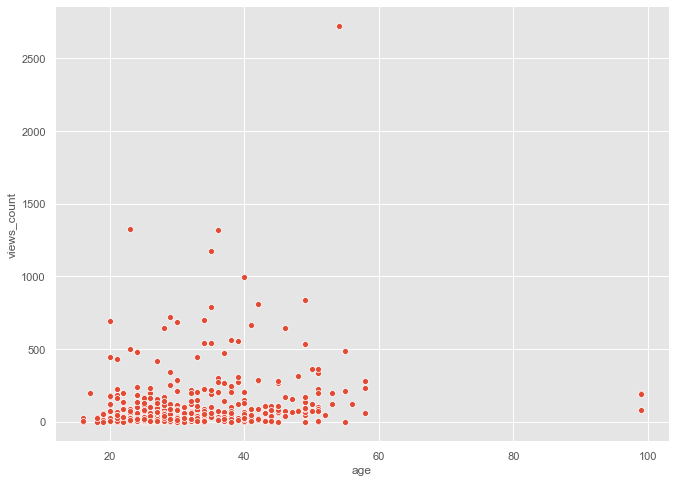

In [1832]:
sns.scatterplot(data=data, x = 'age', y= 'views_count');
#посмотрим на график зависимости количества просмотров от года рождения юзеров с премиум подпиской

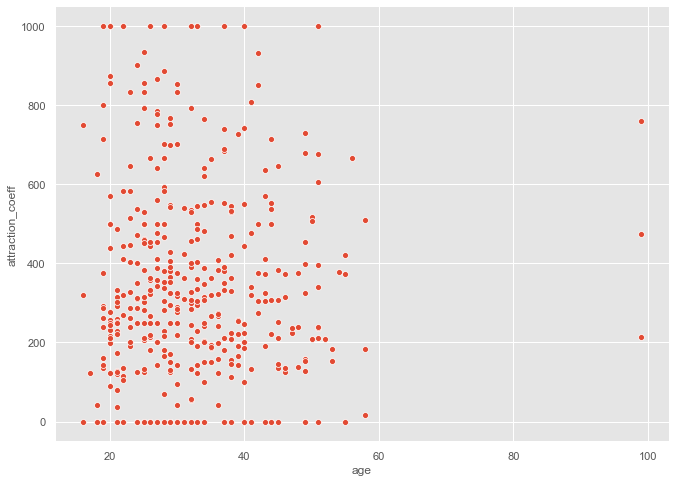

In [1833]:
sns.scatterplot(data=data, x = 'age', y= 'attraction_coeff');
#посмотрим на график зависимости коэффицентра привлекательности от года рождения юзеров с премиум подпиской

In [1834]:
t = []
f = []
for i in (df_all.rank_count.sort_values().unique()):
    for j in group:
        k = df_all[(df_all['group'] == j)&(df_all['rank_count'] == i)&
                   (df_all['is_premium'] == 1)&(df_all['total_revenue']>0)].count().uid
        k_no_buy = df_all[(df_all['group'] == j)&(df_all['rank_count'] == i)].count().uid - k
        g = [k,k_no_buy]
        f.append(g)

In [1835]:
k = 0
z = []
c = []
for i in f:
    z.append(i)
    k = k+1
    if k == 2:
        g, p, dof, expctd = chi2_contingency([z[0],z[1]],correction=False)
        c.append(p)
        z.pop(0)
        k = 0
        z.pop(0)
    else:
        pass

In [1836]:
p_value = pd.DataFrame(c, columns= ['P_value'])
p_value['rank_count'] = df_all.rank_count.sort_values().unique()

In [1837]:
p_value

,P_value,rank_count
0,0.034285,0
1,0.118465,10
2,0.540989,100
3,0.547411,1000


Вывод:
 - Для юзеров у которых просмотров меньше 10, конверсия в покупку премиальной подписки статистически значимо, т.е. менее 
популярные юзеры реже покупают премиальную подписку. Но тут скорее обратная взаимосвязь, если юзер покупает премиальную
подписку он становится более просматриваемым. К тому же количество юзеров имеющие премиальную подписку и имеющие просмотров
меньше 10 в 6 раз меньше чем таких же юзеров у которых просмотров больше 10 просмотров.
 -  Нет никакой причины почему у некоторых юзеров купивших премиальную количество просмотров меньше 10, а других больше 100.
 Было предположение , что это связано с возрастом или временем регистрации, предположение не подтвердилось. Остается вариант, 
 что юзеры с большим количеством просмотров банально имеют эстетически красивые аватарки, которые больше других привлекают
 внимание. Есть взаимосвязь между тем сколько дней находился в приложении и количеством просмотров, чем больше проводил времени
 тем больше просмотров.

## Проверка юзеров разбитых по привлекательности

In [1838]:
df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
      .groupby(['rank_coeff','group'])\
      .agg({'uid':'count'})\
      .pivot_table(index = 'rank_coeff',columns = 'group' , values = 'uid' )\
      .reset_index()
#посмотрим на распределение юзеров, которые отплатали премиум и принесли доход приложению, на группы по коэффиценту 
#привлекательности.

group,rank_coeff,A1,A2,B1
0,0,41,42,30
1,1,63,55,46
2,2,29,19,28
3,3,8,17,12
4,4,10,12,5


In [1839]:
t = []
f = []
for i in range(df_all.rank_coeff.nunique()):
    for j in group:
        k = df_all[(df_all['group'] == j)&(df_all['rank_coeff'] == i)&
                   (df_all['is_premium'] == 1)&(df_all['total_revenue']>0)].count().uid
        k_no_buy = df_all[(df_all['group'] == j)&(df_all['rank_coeff'] == i)].count().uid - k
        g = [k,k_no_buy]
        f.append(g)

In [1840]:
k = 0
z = []
c = []
for i in f:
    z.append(i)
    k = k+1
    if k == 2:
        g, p, dof, expctd = chi2_contingency([z[0],z[1]],correction=False)
        c.append(p)
        z.pop(0)
        k = 0
        z.pop(0)
    else:
        pass

In [1841]:
p_value = pd.DataFrame(c, columns= ['P_value'])
p_value['rank_coeff'] = df_all.rank_coeff.sort_values().unique()

In [1842]:
p_value

,P_value,rank_coeff
0,0.208794,0
1,0.112149,1
2,0.812448,2
3,0.312271,3
4,0.167066,4


Вывод:
 - по результатам анализа группа А от С, статистически ни одна подгруппа статистически не отличается: 
-  возможно мы некорректно произвели разбиение на группы ( 0 группа практически в 3 раза больше 1 группы) и получилось так, что в 0 нулевой
группе были статистические различия, а следующие данные уровняли эти различия.
 - или параметр коэффицент привлекательности никак не связан с конверсией юзеров

## Линейная зависимость между подпиской  на премиальную подписку и выручкой

In [1843]:
X = df_all[['is_premium']].assign(aov=1) #добавим колонку в которой все значения равны 1

In [1844]:
Y = df_all['total_revenue'] # присвоим переменой значения доходов каждого юзера

In [1845]:
estimator = OLS(Y, X).fit()

In [1846]:
print(estimator.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     7168.
Date:                Mon, 21 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:38:20   Log-Likelihood:            -1.1959e+05
No. Observations:               12796   AIC:                         2.392e+05
Df Residuals:                   12794   BIC:                         2.392e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_premium  1.044e+04    123.261     84.666      0.0

Вывод:
    total_value = 10440 X + 50,79
 - среднее значение total_value == 50,79, оно не стат. значимо т.к. P(value)>0.05, другими словами оно случайно
 - P(value ) =0 у коэффицента 5284, говорит нам о том, что можно отвергнуть нулевую гипотезу, что этот коэффицент = 0,
    соответвенно он стат. значим
 - На total_value сильно влияет параметр покупки подписки

## Линейная зависимость между привлекательностью и выручкой

In [1847]:
data = df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)&(df_all['total_revenue'] <30000)]
#возьмем только тех юзеров,которые имеют премиум и принесли доход приложению.
#ограничили юзеров по приносу доходов, чтобы убрать выбросы

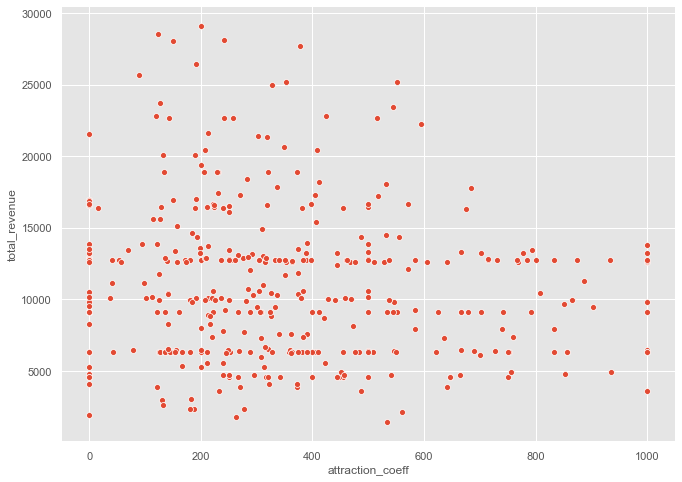

In [1848]:
sns.scatterplot(data=data, x = 'attraction_coeff', y= 'total_revenue');
#посмотрим на график зависимости коэффицентра привлекательности от приносимого дохода юзером с премиум подпиской

In [1849]:
np.corrcoef(data['attraction_coeff'],data['total_revenue']) # расчитаем коэффицент корреляции

array([[ 1.        , -0.11065954],
       [-0.11065954,  1.        ]])

Вывод:
 - связи между коэффицентом привлекательности и выручка принесенная юзером не наблюдается, это видно и по рассеянному облаку 
точек на диаграмме и коэффиценту корреляции = -0.11

## Проверка юзеров разбитых по возрастной группе

In [1850]:
data_age = df_all[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)].groupby(['age','group'],as_index=False)\
                                                                  .agg({'uid':'count'}).sort_values(by='age')
# запишем датасет, в котором юзеры разбиты по возрасту и группе и подсчитано сколько юзеров входит в эту когорту,
#причем все эти юзеры с премиум 

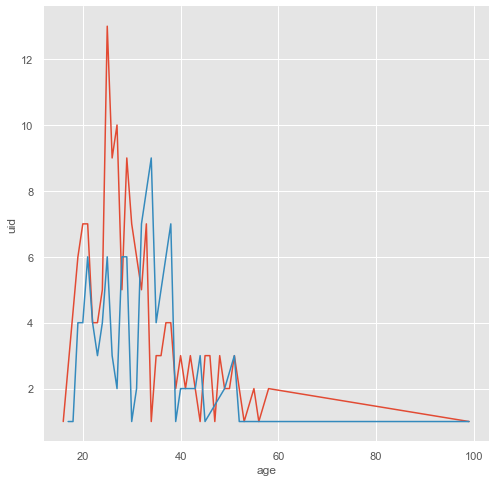

In [1851]:
plt.figure(figsize=(8,8))
sns.lineplot(x='age', y='uid', data=data_age.loc[data_age['group'] == 'A1'])
sns.lineplot(x='age', y='uid', data=data_age.loc[data_age['group'] == 'B1'])
sns.despine()
#построим график количества юзеров от года рождения

In [1852]:
df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
      .groupby(['group','age_group'],as_index = False)\
      .agg({'uid':'count'})\
      .pivot(index='age_group',columns='group',values='uid').reset_index()
#посмотрим сколько на распределение юзеров по группам и по группе возрастов

group,age_group,A1,A2,B1
0,norm,43,53,61
1,old,21,15,9
2,young,87,77,51


In [1853]:
t = []
f = []
for i in df_all.age_group.unique().tolist():
    for j in group:
        k = df_all[(df_all['group'] == j)&(df_all['age_group'] == i)&
                   (df_all['is_premium'] == 1)&(df_all['total_revenue']>0)].count().uid
        k_no_buy = df_all[(df_all['group'] == j)&(df_all['age_group'] == i)].count().uid - k
        g = [k,k_no_buy]
        f.append(g)

In [1854]:
k = 0
z = []
c = []
for i in f:
    z.append(i)
    k = k+1
    if k == 2:
        g, p, dof, expctd = chi2_contingency([z[0],z[1]],correction=False)
        c.append(p)
        z.pop(0)
        k = 0
        z.pop(0)
    else:
        pass

In [1855]:
p_value = pd.DataFrame(c, columns= ['P_value'])
p_value['group_age'] = df_all.age_group.unique().tolist()

In [1856]:
p_value

,P_value,group_age
0,0.001396,young
1,0.062754,norm
2,0.044337,old


In [1857]:
df_all.loc[(df_all['is_premium'] == 1)&(df_all['total_revenue']>0)]\
      .groupby(['group','age_group'],as_index = False)\
      .agg({'total_revenue':'sum'})\
      .pivot(index='age_group',columns='group',values='total_revenue').reset_index()
#какое количество дохов принесли разные возрастные категории

group,age_group,A1,A2,B1
0,norm,494806,638443,1013857
1,old,201253,189826,161135
2,young,1053351,837291,936585


Вывод:
- p-valu <0.05 у группы молодых и старых юзеров, соответственно у этих групп есть стат. различия. А у средней группы юзеров
изменения в оплате никак не повлияло на доход который они приносили приложению.

## Проверка юзеров разбитых по гендерному признаку 

количество юзеров оформившие подписку разбитые на группы и по гендеру

In [1858]:
df_all.loc[df_all['product_typeset'] == "premium_no_trial"]\
        .groupby(['gender','group'],as_index = False)\
        .agg({'uid':'count'})\
        .pivot(index='gender',columns='group',values='uid')\
        .reset_index()\
        .fillna(0)

group,gender,A1,A2,B1
0,0,0.0,4.0,0.0
1,1,86.0,88.0,62.0


общее количество юзеров разбитые на группы и по гендеру

In [1859]:
df_all.groupby(['gender','group'],as_index = False)\
        .agg({'uid':'count'})\
        .pivot(index='gender',columns='group',values='uid')\
        .reset_index()

group,gender,A1,A2,B1
0,0,182,190,197
1,1,4120,4028,4079


конверсия юзеров в платную подписку (по группам и полу)

In [1860]:
(df_all.loc[df_all['product_typeset'] == "premium_no_trial"]
        .groupby(['gender','group'],as_index = False)\
        .agg({'uid':'count'})\
        .pivot(index='gender',columns='group',values='uid')\
        .reset_index()\
        .fillna(0)\
        /df_all.groupby(['gender','group'],as_index = False)\
        .agg({'uid':'count'})\
        .pivot(index='gender',columns='group',values='uid')\
        .reset_index())\
        .fillna(0)

group,gender,A1,A2,B1
0,0.0,0.000000,0.021053,0.0000
1,1.0,0.020874,0.021847,0.0152


Вывод:
- нет смысла проверять стат. значимость влияния гендера на конверсию :
    -отсутвие женщин купивших премиум подписку 

#  Вывод:
- Был ли эксперимент успешен в целом.
    - конверсия в покупку премиальной версии уменьшилась на 19.6%
    - средняя выручка на одного пользователя увеличилась на 17.8%
    - В целом эксперимент считаю неуспешным, так как конверсия в премиальную подписку уменьшилась, статически  значимо, но в тоже время конверсия в премиум юзеров, которые потратили хотя бы 1 доллар уже статистически не изменилась. В эксперименте средний доход клиента,который приобрел премиум упал на 17.8%, что является стат. значимо. Я бы сделал бы все таки упор на повышение конверсии, так как это в долгосрочной перспективе принесет больше прибыли.

- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
   - Для юзеров в возрасте от 31 до 45 лет включительно новводение имеет смысл: у них поднялась конверсия и суммарный доход 
   от всех юзеров. Это можно объсянить тем, что это самая платежеспособная группа.
   - Для всех юзеров разбитых по континентам конверсия в покупку премиума не показала стат. различии, нужно рассматривать 
   каждую страну в отдельности, или разбить страны по уровню покупательной способности это нам покажет более ясную картину
 
 Мои рекомендации не выкатывать продукт, а если и выкатывать, то только мужчин в возрасте от 31-45 лет. А также провести еще один A/B тест, только уже на длительный промежуток времени, так как для того, чтобы зафиксировать изменение конверсии в покупку
 премиума нужно больше данных по юзерам.